# imports & settings

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%precision %.3f

from glob import glob
from tqdm import tqdm

from os.path import join
import ntpath 
from copy import deepcopy

import pytz
TZ = pytz.FixedOffset(540) # GMT+09:00; Asia/Seoulsilent

from sklearn import metrics 
from sklearn.model_selection import GroupKFold

import warnings
from functools import reduce
from itertools import product

import matplotlib
matplotlib.rc('font', size=22)
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
import sys  
sys.path.insert(0, '../') # to import from parent directory
import utils
from utils import *
import recept_dataset
from f_preprocessing import impute_support_features, impute, normalize



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
RANDOM_STATE=utils.RANDOM_STATE
DATAROOT = utils.DATAROOT
BALANCED_TRAINING = False
ALREADY_EXTRACTED_SUBFEATURES = True

## Function definitions for classification experiment

### metrics

In [4]:
def perf_metrics(y_true: np.ndarray, y_pred: np.ndarray):
    y_pred_cls = np.rint(y_pred)    

    with warnings.catch_warnings():
        warnings.simplefilter("ignore") 
        acc = metrics.accuracy_score(y_true, y_pred_cls)
        acc_bal = metrics.balanced_accuracy_score(y_true, y_pred_cls)
        f1_score = metrics.f1_score(
            y_true=y_true, y_pred=y_pred_cls,average='macro',pos_label=1
        )
        auc = metrics.roc_auc_score(
            y_true=y_true, y_score=y_pred, average='macro'
        )

    return dict(
        ACC=acc*100
        , ACC_BAL=acc_bal*100
        , F1_score = f1_score
        , AUC=auc
    )


### classifiers

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import catboost

classifiers = {
    'lr':LogisticRegression(random_state = RANDOM_STATE, max_iter=500 )
    ,'knn':KNeighborsClassifier(),
    'svm':SVC(probability=True),
    'gp':GaussianProcessClassifier(),
    'dt':DecisionTreeClassifier(random_state = RANDOM_STATE),
    'rf':RandomForestClassifier(random_state = RANDOM_STATE),
    'mlp':MLPClassifier(),
    'adaboost':AdaBoostClassifier(),
    'gnb':GaussianNB(),
    'qda':QuadraticDiscriminantAnalysis(),
    'catboost': catboost.CatBoostClassifier(
        random_seed=RANDOM_STATE, eval_metric='AUC'
    )    
}

classifier_names = {
    'lr':'LogisticRegression'
    ,'knn':'KNeighborsClassifier',
    'svm':'SVM',
    'gp':'GaussianProcess',
    'dt':'DecisionTree',
    'rf':'RandomForest',
    'mlp':'Multi-layer Perceptron',
    'adaboost':'AdaBoost',
    'gnb':'Gaussian Naive Bayes',
    'qda':'QuadraticDiscriminantAnalysis',
    'catboost':'CatBoost'
}

### run_classification

In [6]:
def run_classification(
    df, use_ray = True,  cat_features=None, classifier_name='catboost',
    feature_selection = None, experiment_name=''
) :   
    y = df['receptivity'].replace({
        'receptive':1,'non-receptive':0
    })
    X = df.drop(columns='receptivity')
    pids = df.index.get_level_values('pid')

    results = LOGO_5fold(
        X,y, pids, feature_selection=feature_selection,
        cat_features=cat_features,
        classifier_name=classifier_name
        ,use_ray=use_ray
    )
    
    results.insert(results.shape[1], 'experiment',experiment_name)
    return results
    


### CV

In [7]:
def LOGO_5fold(
    X,y, pids, cat_features=None, classifier_name='catboost',
    feature_selection = None
    , use_ray=False
):
    func = ray.remote(run_trial).remote if use_ray else run_trial
    results = []    
    for train_index, test_index in tqdm(
        GroupKFold(n_splits=5).split(X, y, groups=pids)
    ):        
        res = func(
            X,y, train_index,test_index,
            cat_features=cat_features, classifier_name=classifier_name,
            feature_selection = feature_selection
        )
        results.append(res) 
    results = ray.get(results) if use_ray else results
    results = pd.DataFrame(results)
    results.insert(results.shape[1],'CV_TYPE','LOGO_5fold')
    return results

### run trial

In [8]:
def run_trial(X, y,  train_index,test_index,             
              feature_selection = None, cat_features=None, 
              classifier_name='catboost'):

    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    
    if BALANCED_TRAINING:
        X_train, y_train = balance_data(X_train, y_train)
        
    if feature_selection['status']:
        selected_features = select_features(X_train, y_train, feature_selection)
        X_train = X_train[selected_features]
        
    feature_names =X_train.columns.tolist()
    clf = classifiers[classifier_name]
    if classifier_name=='catboost': # cuz it is slightly different than sklearn API
        d_train = catboost.Pool(
            data = X_train,
            label = y_train,
            feature_names = feature_names,
            cat_features = cat_features
        )
        clf.fit(X = d_train, verbose_eval=False, early_stopping_rounds=20)
    else:
        clf.fit(X_train, y_train)
        
    prob = clf.predict_proba(X.iloc[test_index])[:,1]
    test_metrics = perf_metrics(y.iloc[test_index], prob)    

    prob = clf.predict_proba(X.iloc[train_index])[:,1]
    train_metrics = perf_metrics(y.iloc[train_index], prob)

    res = {f'TEST_{k}':v  for k,v in test_metrics.items()}
    res.update({f'TRAIN_{k}':v  for k,v in train_metrics.items()})
    return res    

### balance data

In [9]:
from imblearn.over_sampling import RandomOverSampler

def balance_data(X_train, y_train):
    ros = RandomOverSampler(random_state=RANDOM_STATE)
    X_train, y_train = ros.fit_resample(X_train, y_train)
    return X_train, y_train
    

### feature selection

In [10]:
from sklearn.linear_model import  Lasso
def select_features(X_train, y_train, feature_selection):
    if feature_selection['method']=='LASSO':
        classifier = Lasso(tol=1e-3)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            classifier.fit(X=X_train, y=y_train)
        coef=np.abs(classifier.coef_)
        I = coef.argsort()
        keep_ratio=feature_selection['keep_ratio']
        num_features_to_keep = int(keep_ratio*X_train.shape[1])            

        X_train =  X_train[X_train.columns[I[-1*num_features_to_keep:]]]
        return X_train.columns.tolist()
        

# Data Split

In [11]:
import random
random.seed(RANDOM_STATE)

labels = pd.read_csv(
    join(DATAROOT,'binned_esm_data.csv'), 
    dtype={
            'valence':float
            ,'arousal': float
            ,'attention': float
            ,'stress': float
            ,'duration': float
            ,'change': float
            , 'pid':str            
        },
    parse_dates=['timestamp']
).set_index(['pid','timestamp'])

pids = labels.index.get_level_values('pid').unique().tolist()

random.shuffle(pids)
N = len(pids)
r = .5 # rule mining pariticpants ratio
arm_pids = pids[:int(N*r)]

labels_arm = labels[labels.index.get_level_values('pid').isin(arm_pids)]
labels_ml = labels[~labels.index.get_level_values('pid').isin(arm_pids)]
labels_arm.shape, labels_ml.shape
print("arm_pids",len(np.unique(arm_pids)),'ml_pids'
      , len(np.unique(pids))-len(np.unique(arm_pids)))

arm_pids 36 ml_pids 37


In [12]:
labels_arm.shape, labels_ml.shape

((1677, 20), (1657, 20))

# RuleGenerateSet


In [13]:
labels_arm.receptivity.value_counts()

receptive        940
non-receptive    737
Name: receptivity, dtype: int64

In [14]:
labels_ml.receptivity.value_counts()

receptive        998
non-receptive    659
Name: receptivity, dtype: int64

## functions

### remove pairwise correlations

In [15]:
def remove_pairwise_corr(Matrix, PAIRWISE_CORR_THRESHOLD = 0.8):
    
    eliminated_features = []
    for r in range(Matrix.shape[0]):
        featurename = Matrix.index[r]   
        if str(featurename) in eliminated_features:
            continue
        pairwise_corr = Matrix.iloc[r,:r]
        eliminated_features+= pairwise_corr[
            pairwise_corr>PAIRWISE_CORR_THRESHOLD
        ].index.to_list()

    kept_features_after_pairwise_correlation = list(
        set(Matrix.index.to_list()) - set(eliminated_features)
    )
    return kept_features_after_pairwise_correlation


### discretize / recode

In [16]:
from copy import deepcopy        
def discretize_df(data, cols, pid):
    df = deepcopy(data)
    count1,count2, count3 = 0,0,0
    for col in cols:
        try:
            df[col] = pd.qcut(df[col], 3, labels=["l","m","h"])
            count3 += 1
        except:
            try:
                df[col] = pd.qcut(df[col], 2, labels=["l","h"])
                count2 += 1
            except:
                df[col] = pd.qcut(df[col], 1, labels=["m"])
                count1 += 1
    df.insert(0,'pid',pid)
    df = df.reset_index().set_index(['pid']+data.index.names)
    return df

## rule mining has the concept of transaction
- this is the number of cases available in our database
- based on those cases we mine rules 

In [17]:

num_participants = labels_arm.index.get_level_values('pid').nunique()


sub_winsize = 20 # min
num_transactions = num_participants*utils.COLLECTION_DAYS*\
    utils.COLLECTION_HOURS*utils.MIN_IN_HOUR//sub_winsize
num_transactions

9072

## window size selection
- which window size
    - 40  MIN
    - 80  MIN
    

- how many sub window size
    - 2
    - 4
    - 8

In [18]:
windows = [40,80,160]
num_sub_windows = [2,4,8]


#### Extract sub features

In [103]:
_pid = '3014'
recept_dataset.extract_sub(
    _pid= _pid,
    _label= labels_arm.loc[_pid]
    , w_size_in_min=40
    , num_sub = 2
    ,  pba=None, selected_features=None
    , resample = False
)

appUsage_appPackage#ETP  \
pid  timestamp           sub_timestamp                                  
3014 2019-04-30 10:56:50 2019-04-30 10:36:50                    1.801   
                         2019-04-30 10:56:50                      NaN   
     2019-04-30 13:43:30 2019-04-30 13:23:30                      NaN   
                         2019-04-30 13:43:30                      NaN   
     2019-04-30 14:30:25 2019-04-30 14:10:25                      NaN   
                         2019-04-30 14:30:25                      NaN   
     2019-04-30 15:10:26 2019-04-30 14:50:26                      NaN   
                         2019-04-30 15:10:26                      NaN   
     2019-04-30 16:41:41 2019-04-30 16:21:41                      NaN   
                         2019-04-30 16:41:41                    1.083   
     2019-04-30 19:41:58 2019-04-30 19:21:58                    1.467   
                         2019-04-30 19:41:58                    1.299   
     2019-05-01 10:39:39 2019-05-01 10:19:39                    1.285   
                         2019-05-01 10:39:39                    1.835   
     2019-05-01 11:27:36 2019-05-01 11:07:36                      NaN   
                         2019-05-01 11:27:36                    1.066   
     2019-05-01 12:09:23 2019-05-01 11:49:23                    1.384   
                         2019-05-01 12:09:23                    1.189   
     2019-05-01 12:54:55 2019-05-01 12:34:55                    1.593   
                         2019-05-01 12:54:55                    1.398   
     2019-05-01 13:41:36 2019-05-01 13:21:36                    1.097   
                         2019-05-01 13:41:36                    1.481   
     2019-05-01 14:24:25 2019-05-01 14:04:25                    1.154   
                         2019-05-01 14:24:25                    1.460   
     2019-05-01 16:39:16 2019-05-01 16:19:16                    1.377   
                         2019-05-01 16:39:16                    1.434   
     2019-05-01 18:55:27 2019-05-01 18:35:27                    1.238   
                         2019-05-01 18:55:27                    1.456   

                                              appUsage_appPackage#ASC  \
pid  timestamp           sub_timestamp                                  
3014 2019-04-30 10:56:50 2019-04-30 10:36:50                  120.000   
                         2019-04-30 10:56:50                      NaN   
     2019-04-30 13:43:30 2019-04-30 13:23:30                      NaN   
                         2019-04-30 13:43:30                      NaN   
     2019-04-30 14:30:25 2019-04-30 14:10:25                      NaN   
                         2019-04-30 14:30:25                      NaN   
     2019-04-30 15:10:26 2019-04-30 14:50:26                      NaN   
                         2019-04-30 15:10:26                      NaN   
     2019-04-30 16:41:41 2019-04-30 16:21:41                      NaN   
                         2019-04-30 16:41:41                   56.000   
     2019-04-30 19:41:58 2019-04-30 19:21:58                  171.000   
                         2019-04-30 19:41:58                  179.000   
     2019-05-01 10:39:39 2019-05-01 10:19:39                   80.000   
                         2019-05-01 10:39:39                   58.000   
     2019-05-01 11:27:36 2019-05-01 11:07:36                      NaN   
                         2019-05-01 11:27:36                   44.000   
     2019-05-01 12:09:23 2019-05-01 11:49:23                  112.000   
                         2019-05-01 12:09:23                  129.000   
     2019-05-01 12:54:55 2019-05-01 12:34:55                  147.000   
                         2019-05-01 12:54:55                   38.000   
     2019-05-01 13:41:36 2019-05-01 13:21:36                   55.000   
                         2019-05-01 13:41:36                   74.000   
     2019-05-01 14:24:25 2019-05-01 14:04:25                  335.000   
                         2019-

In [107]:
from itertools import product
import os.path as osp
with on_ray(object_store_memory=2e10, ignore_reinit_error=True, num_cpus=40):    
    #for nsub, window_size_in_min in product(num_sub_windows,windows)[1:]:
    for i,(nsub, window_size_in_min) in enumerate(product(num_sub_windows,windows)):
        if i==0:
            continue

        fn = f'feature/arm/subfeature_{window_size_in_min}MIN_{nsub}.csv'
        print(fn)
        if 1==1:#not osp.exists(fn):
            print(f'extracting {fn} ')
            sub_features = recept_dataset.parallellize_extract_sub(
                labels=labels_arm
                , w_size_in_min = window_size_in_min
                ,num_sub=nsub
                , resample=False
            )
            sub_features.to_csv(
                f'feature/arm/subfeature_{window_size_in_min}MIN_{nsub}.csv')

feature/arm/subfeature_80MIN_2.csv
extracting feature/arm/subfeature_80MIN_2.csv 


  0%|          | 0/36 [00:00<?, ?it/s]

feature/arm/subfeature_160MIN_2.csv
extracting feature/arm/subfeature_160MIN_2.csv 


100%|██████████| 36/36 [13:41<00:00, 22.81s/it]  


feature/arm/subfeature_40MIN_4.csv
extracting feature/arm/subfeature_40MIN_4.csv 


  0%|          | 0/36 [00:00<?, ?it/s]

feature/arm/subfeature_80MIN_4.csv
extracting feature/arm/subfeature_80MIN_4.csv 


  0%|          | 0/36 [00:00<?, ?it/s]

feature/arm/subfeature_160MIN_4.csv
extracting feature/arm/subfeature_160MIN_4.csv 


100%|██████████| 36/36 [13:08<00:00, 21.90s/it]  


feature/arm/subfeature_40MIN_8.csv
extracting feature/arm/subfeature_40MIN_8.csv 


100%|██████████| 36/36 [12:59<00:00, 21.64s/it]  


feature/arm/subfeature_80MIN_8.csv
extracting feature/arm/subfeature_80MIN_8.csv 


100%|██████████| 36/36 [13:40<00:00, 22.78s/it]  


feature/arm/subfeature_160MIN_8.csv
extracting feature/arm/subfeature_160MIN_8.csv 


100%|██████████| 36/36 [13:53<00:00, 23.17s/it]  


#### select window size

##### find missing features per combination

In [108]:
measurement = pd.DataFrame( columns=[
    'number of subwindows'
    ,'window size'
])

for nsub, window_size_in_min in product(num_sub_windows,windows):
    sub_features = pd.read_csv(
        f'feature/arm/subfeature_{window_size_in_min}MIN_{nsub}.csv'
    ).set_index(['pid','timestamp','sub_timestamp']) 
    N,D = sub_features.shape

    sub_features = impute_support_features(sub_features)
    ds = sub_features.isnull().sum(axis=0)/N
    
    measurement = pd.concat(
        [
            measurement
            ,pd.DataFrame({
                'number of subwindows':[nsub]
                ,'window size':[window_size_in_min]
                ,r'missing features % (threshold=20%)':[ds[ds>.02].sum()/D*100]
            })
        ]
        , ignore_index=True
    )

pd.set_option("display.precision", 2)

measurement = measurement.set_index([
    'number of subwindows','window size'
]).sort_index()
measurement.to_csv(f'setting/missing_feature_for_each_combinations.csv')
measurement

missing features % (threshold=20%)  \
number of subwindows window size                                       
2                    40                                       14.362   
                     80                                       12.375   
                     160                                      10.930   
4                    40                                       16.936   
                     80                                       15.103   
                     160                                      13.904   
8                    40                                       19.356   
                     80                                       17.592   
                     160                                      16.647   

                                  missing features % (threshold=10%)  
number of subwindows window size                                      
2                    40                                       14.362  
                     80                                       12.375  
                     160                                      10.930  
4                    40                                       16.936  
                     80                                       15.103  
                     160                                      13.904  
8                    40                                       19.356  
                     80                                       17.592  
                     160                                      16.647

In [87]:
N,D = sub_features.shape
sub_features.isnull().sum()

appUsage_appPackage#ETP                    56
appUsage_appPackage#ASC                    56
appUsage_appCategory#ETP                   56
appUsage_appCategory#ASC                   56
appUsage_appCategory#SUP:Tools              0
                                           ..
ringer#SUP:RINGER_MODE_NORMAL               0
activity_event#SUP:RUNNING                  0
appUsage_appCategory#SUP:Shopping           0
appUsage_appCategory#SUP:Health/Fitness     0
battery_plugState#SUP:WIRELESS              0
Length: 389, dtype: int64

In [111]:
import os
WINDOW_SIZE_IN_MIN = 160
NSUB = 4 
fn = f'feature/arm/subfeature_{WINDOW_SIZE_IN_MIN}MIN_{NSUB}.csv'
if os.path.exists(fn):
    sub_features = pd.read_csv(fn).set_index(['pid','timestamp','sub_timestamp'])
    sub_features = impute_support_features(sub_features)
else:
    sub_features = recept_dataset.parallellize_extract_sub(
                    labels=labels_arm
                    , w_size_in_min = WINDOW_SIZE_IN_MIN
                    ,num_sub=NSUB
                )
    sub_features.to_csv(fn)

100%|██████████| 36/36 [14:25<00:00, 24.05s/it]  


In [112]:
sub_features

appUsage_appPackage#ETP  \
pid  timestamp           sub_timestamp                                  
3024 2019-04-30 10:05:31 2019-04-30 08:05:31                      NaN   
                         2019-04-30 08:45:31                      NaN   
                         2019-04-30 09:25:31                    0.426   
                         2019-04-30 10:05:31                    0.123   
     2019-04-30 10:05:32 2019-04-30 08:05:32                      NaN   
...                                                               ...   
3029 2019-05-06 21:08:16 2019-05-06 21:08:16                    0.000   
     2019-05-06 21:57:12 2019-05-06 19:57:12                    0.556   
                         2019-05-06 20:37:12                    0.000   
                         2019-05-06 21:17:12                    0.000   
                         2019-05-06 21:57:12                    0.000   

                                              appUsage_appPackage#ASC  \
pid  timestamp           sub_timestamp                                  
3024 2019-04-30 10:05:31 2019-04-30 08:05:31                      NaN   
                         2019-04-30 08:45:31                      NaN   
                         2019-04-30 09:25:31                   19.000   
                         2019-04-30 10:05:31                    6.000   
     2019-04-30 10:05:32 2019-04-30 08:05:32                      NaN   
...                                                               ...   
3029 2019-05-06 21:08:16 2019-05-06 21:08:16                    0.000   
     2019-05-06 21:57:12 2019-05-06 19:57:12                   11.000   
                         2019-05-06 20:37:12                    0.000   
                         2019-05-06 21:17:12                    0.000   
                         2019-05-06 21:57:12                    0.000   

                                              appUsage_appCategory#ETP  \
pid  timestamp           sub_timestamp                                   
3024 2019-04-30 10:05:31 2019-04-30 08:05:31                       NaN   
                         2019-04-30 08:45:31                       NaN   
                         2019-04-30 09:25:31                     0.285   
                         2019-04-30 10:05:31                     0.092   
     2019-04-30 10:05:32 2019-04-30 08:05:32                       NaN   
...                                                                ...   
3029 2019-05-06 21:08:16 2019-05-06 21:08:16                     0.000   
     2019-05-06 21:57:12 2019-05-06 19:57:12                     0.534   
                         2019-05-06 20:37:12                     0.000   
                         2019-05-06 21:17:12                     0.000   
                         2019-05-06 21:57:12                     0.000   

                                              appUsage_appCategory#ASC  \
pid  timestamp           sub_timestamp                                   
3024 2019-04-30 10:05:31 2019-04-30 08:05:31                       NaN   
                         2019-04-30 08:45:31                       NaN   
                         2019-04-30 09:25:31                     4.000   
                         2019-04-30 10:05:31                     2.000   
     2019-04-30 10:05:32 2019-04-30 08:05:32                       NaN   
...                                                                ...   
3029 2019-05-06 21:08:16 2019-05-06 21:08:16                     0.000   
     2019-05-06 21:57:12 2019-05-06 19:57:12                     8.000   
                         2019-05-06 20:37:12                     0.000   
                         2019-05-06 21:17:12                     0.000   
                         2019-05-06 21:57:12                     0.000   

                                              appUsage_appCategory#SUP:Tools  \
pid  timestamp           sub_timestamp                                         
3024 2019-04-30 10:05:31 2019-04-30 08:05:31                

In [113]:
sub_features.isnull().sum()

appUsage_appPackage#ETP                    21
appUsage_appPackage#ASC                    21
appUsage_appCategory#ETP                   21
appUsage_appCategory#ASC                   21
appUsage_appCategory#SUP:Tools              0
                                           ..
ringer#SUP:RINGER_MODE_NORMAL               0
activity_event#SUP:RUNNING                  0
appUsage_appCategory#SUP:Shopping           0
appUsage_appCategory#SUP:Health/Fitness     0
battery_plugState#SUP:WIRELESS              0
Length: 389, dtype: int64

### aggregated features 


#### compute

In [114]:
EXTRACTED_AGGRAGETED = False

def read_sub_features(window_size_in_min=WINDOW_SIZE_IN_MIN, nsub=NSUB):
    fn = f'feature/arm/subfeature_{window_size_in_min}MIN_{nsub}.csv'
    sub_features = pd.read_csv(
        fn
        ,dtype={'pid':str}
        ,parse_dates=['timestamp','sub_timestamp']
    ).set_index(['pid','timestamp','sub_timestamp'])
    return sub_features


def extract_agg_features(window_size_in_min=WINDOW_SIZE_IN_MIN, nsub=NSUB):
    fn = f'feature/arm/agg_feature_{window_size_in_min}MIN_{nsub}.csv'
    sub_features = read_sub_features(window_size_in_min, nsub)
    sub_features_preprocessed = normalize(
        impute_support_features(sub_features)
    )

    agg_feature = sub_features_preprocessed.groupby(
        ['pid','timestamp']
    ).agg(['mean','std'])
    agg_feature.columns = agg_feature.columns.map('|'.join).str.strip('|')
    agg_feature.to_csv(fn)

In [115]:
import recept_dataset 
if not EXTRACTED_AGGRAGETED:
    extract_agg_features()
    
agg_feature = pd.read_csv(
    f'feature/arm/agg_feature_{WINDOW_SIZE_IN_MIN}MIN_{NSUB}.csv'
    ,dtype={'pid':str}         
    ,parse_dates=['timestamp']
).set_index(['pid','timestamp'])
agg_feature.isnull().sum(axis=0).sort_values(ascending=False)

unlock#ETP|std                          1677
headsetEvent#ASC|std                    1677
headsetEvent#ASC|mean                   1677
headsetEvent#ETP|std                    1677
headsetEvent#ETP|mean                   1677
                                        ... 
battery_status#SUP:DISCHARGING|mean        0
battery_plugState#SUP:UNDEFINED|std        0
battery_plugState#SUP:UNDEFINED|mean       0
bandUV_indexLevel#SUP:LOW|std              0
battery_plugState#SUP:WIRELESS|std         0
Length: 778, dtype: int64

#### Feature selection

##### missing count thresholding
- discard if the feature is missing more than 20% of the time

10/778 removed


Text(0, 0.5, 'Percentage of missing cases')

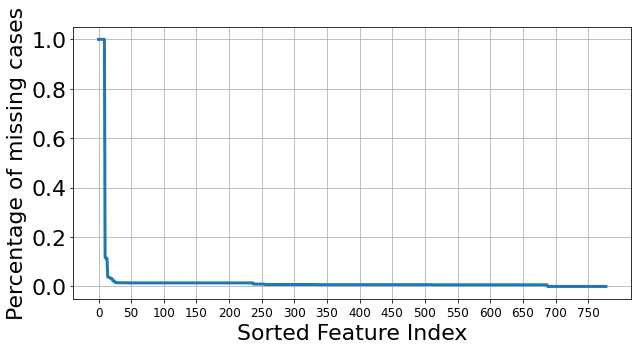

In [117]:
missing_ratio = agg_feature.isnull().sum(axis=0)/len(agg_feature)

agg_feature_percent_missing  = agg_feature.loc[
    :,(missing_ratio[missing_ratio<.2]).index
]
num_removed = agg_feature.shape[1]-agg_feature_percent_missing.shape[1]
print(f"{num_removed}/{agg_feature.shape[1]} removed")

# visuzlize missing ratio
plt.figure(figsize=(10,5))
N, D = agg_feature.shape
missing_ratio.sort_values(ascending=False).plot(linewidth=3)
I = np.arange(0,D,50)
plt.xticks(I,I, fontsize=12);
plt.grid()
plt.xlabel('Sorted Feature Index')
plt.ylabel('Percentage of missing cases')


##### Pairwise Correlation

###### prepare features order
- features highly correlated with target variable should come first in corr matrix


In [118]:
corr_with_outcome = pd.merge(
    labels_arm[['disturbance']],
    agg_feature_percent_missing
    ,left_index=True, right_index=True
).corr()['disturbance'].abs().sort_values(ascending=False)

corr_with_outcome

disturbance                               1.000
ringer#SUP:RINGER_MODE_NORMAL|mean        0.304
data_RX2TX#MAX|std                        0.261
data_TX#ASC|std                           0.203
data_TX#MAX|mean                          0.202
                                           ... 
bandSkinTemperature_temperature#MED|std   0.000
battery_temperature#VAR|mean              0.000
bandUV_exposure#SKW|mean                  0.000
bandSkinTemperature_temperature#AVG|std   0.000
bandCalory_burned#MAX|mean                0.000
Name: disturbance, Length: 769, dtype: float64

In [119]:
importance_order = corr_with_outcome.index.to_list()[1:] # remove `disturbance`
Matrix = agg_feature_percent_missing[importance_order].corr()

Matrix

,ringer#SUP:RINGER_MODE_NORMAL|mean,data_RX2TX#MAX|std,data_TX#ASC|std,data_TX#MAX|mean,data_TX#ASC|mean,data_RX2TX#VAR|std,data_RX2TX#MAX|mean,accelerometer_Y#LTI|mean,accelerometer_Y#AVG|mean,accelerometer_Y#MED|mean,...,bandSkinTemperature_temperature#LTS|std,wifi_numConnections#KUR|std,bandUV_exposure#SKW|std,bandSkinTemperature_temperature#MAXLAG|std,bandCalory_burned#MIN|std,bandSkinTemperature_temperature#MED|std,battery_temperature#VAR|mean,bandUV_exposure#SKW|mean,bandSkinTemperature_temperature#AVG|std,bandCalory_burned#MAX|mean
ringer#SUP:RINGER_MODE_NORMAL|mean,1.000,-0.070,0.397,0.413,0.381,-0.063,-0.035,-0.162,-0.163,-0.162,...,-0.057,0.030,-0.025,-0.043,-0.057,-0.056,-0.069,-0.042,-0.056,-0.068
data_RX2TX#MAX|std,-0.070,1.000,-0.030,-0.024,-0.048,0.572,0.636,0.041,0.043,0.037,...,0.046,0.074,-0.047,0.025,-0.022,0.017,0.113,-0.061,0.020,-0.016
data_TX#ASC|std,0.397,-0.030,1.000,0.822,0.912,-0.040,0.004,-0.190,-0.179,-0.174,...,0.030,0.064,-0.032,-0.021,-0.028,0.059,-0.010,-0.027,0.046,-0.024
data_TX#MAX|mean,0.413,-0.024,0.822,1.000,0.890,-0.043,0.016,-0.167,-0.153,-0.149,...,0.021,0.068,-0.026,-0.013,-0.032,0.052,-0.016,-0.024,0.043,-0.035
data_TX#ASC|mean,0.381,-0.048,0.912,0.890,1.000,-0.039,0.019,-0.178,-0.163,-0.160,...,0.023,0.057,-0.031,-0.010,-0.033,0.048,-0.015,-0.027,0.036,-0.032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bandSkinTemperature_temperature#MED|std,-0.056,0.017,0.059,0.052,0.048,-0.013,0.042,-0.032,-0.026,-0.025,...,0.513,0.049,0.032,0.022,0.029,1.000,0.106,0.044,0.982,0.028
battery_temperature#VAR|mean,-0.069,0.113,-0.010,-0.016,-0.015,-0.002,0.122,-0.060,-0.064,-0.063,...,0.139,0.028,0.025,0.082,0.019,0.106,1.000,0.018,0.098,0.047
bandUV_exposure#SKW|mean,-0.042,-0.061,-0.027,-0.024,-0.027,-0.007,-0.015,-0.077,-0.073,-0.068,...,0.077,-0.016,0.906,-0.006,-0.003,0.044,0.018,1.000,0.050,-0.025
bandSkinTemperature_temperature#AVG|std,-0.056,0.020,0.046,0.043,0.036,-0.011,0.041,-0.035,-0.028,-0.027,...,0.495,0.046,0.038,0.029,0.034,0.982,0.098,0.050,1.000,0.033


In [ ]:
top100_correlated_features = list(
    set(map(lambda x: x[:x.find('|')], importance_order[1:101]))
)
pd.DataFrame({'feature':top100_correlated_features}).to_csv(
    'top100_correlates.csv'
)
len(top100_correlated_features)

82

In [ ]:
import pandas
pd.set_option("display.precision", 2)
Matrix.iloc[:10,:10].style.background_gradient(cmap='coolwarm')

,ringer#SUP:RINGER_MODE_NORMAL|mean,data_RX2TX#MAX|std,accelerometer_Y#AVG|mean,accelerometer_Y#LTI|mean,accelerometer_Y#MED|mean,data_RX2TX#VAR|std,accelerometer_Y#MAX|mean,data_TX#MAX|mean,data_TX#ASC|mean,data_TX#ASC|std
ringer#SUP:RINGER_MODE_NORMAL|mean,1.00,-0.04,-0.16,-0.15,-0.15,-0.05,-0.15,0.38,0.35,0.35
data_RX2TX#MAX|std,-0.04,1.00,0.05,0.05,0.05,0.60,0.04,-0.00,-0.01,0.00
accelerometer_Y#AVG|mean,-0.16,0.05,1.00,0.99,1.00,0.08,0.66,-0.13,-0.14,-0.13
accelerometer_Y#LTI|mean,-0.15,0.05,0.99,1.00,0.99,0.08,0.65,-0.13,-0.13,-0.12
accelerometer_Y#MED|mean,-0.15,0.05,1.00,0.99,1.00,0.09,0.65,-0.13,-0.13,-0.13
data_RX2TX#VAR|std,-0.05,0.60,0.08,0.08,0.09,1.00,0.06,-0.03,-0.03,-0.02
accelerometer_Y#MAX|mean,-0.15,0.04,0.66,0.65,0.65,0.06,1.00,-0.09,-0.07,-0.08
data_TX#MAX|mean,0.38,-0.00,-0.13,-0.13,-0.13,-0.03,-0.09,1.00,0.89,0.78
data_TX#ASC|mean,0.35,-0.01,-0.14,-0.13,-0.13,-0.03,-0.07,0.89,1.00,0.93
data_TX#ASC|std,0.35,0.00,-0.13,-0.12,-0.13,-0.02,-0.08,0.78,0.93,1.00


###### selection with pairwise correlation
- find features to be eliminate
- store kept features

In [120]:
print("Matrix.shape",Matrix.shape)
kept_features_after_pairwise_correlation = remove_pairwise_corr(Matrix)
print(len(kept_features_after_pairwise_correlation))

Matrix.shape (768, 768)
401


###### fit classifier after eliminating multi colliniearity

In [121]:
feature_selection={'status':False}
use_ray = False

measure = run_classification(
    pd.merge(
        labels_arm[['receptivity']],
        impute(
            agg_feature_percent_missing[kept_features_after_pairwise_correlation]
        )
        ,left_index=True, right_index=True
    )
    ,use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='lr'
    , classifier_name='lr'
)
measure.groupby(['CV_TYPE','experiment']).mean()

5it [00:00,  7.59it/s]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,lr,56.633,54.564,0.534,0.567,77.833,76.362,0.768,0.854


##### LogReg+Lasso 

In [122]:

from random import random

data = pd.merge(
        labels_arm[['receptivity']],
        impute(
            agg_feature_percent_missing[kept_features_after_pairwise_correlation]
        )
        ,left_index=True, right_index=True
)

clf = LogisticRegression(penalty='l1', solver='saga', C=1, random_state=RANDOM_STATE)
clf.fit(
    data.drop(['receptivity'], axis=1)
    , data['receptivity']
)


/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


LogisticRegression(C=1, penalty='l1', random_state=42, solver='saga')

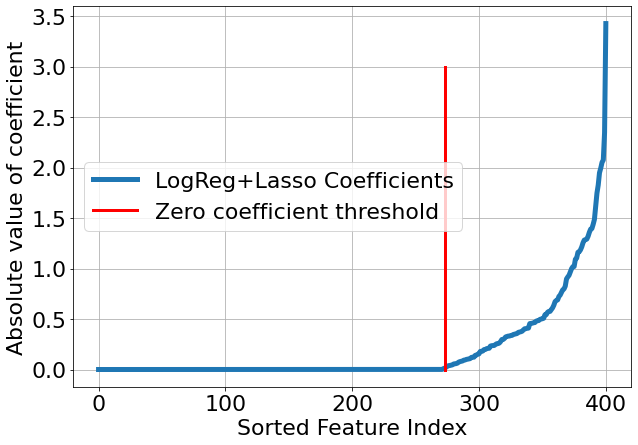

In [123]:
matplotlib.rc('font', size=22)

plt.figure(figsize=(10,7))
plt.grid()
plt.plot(np.sort(np.abs(clf.coef_[0])), linewidth=5, 
    label = 'LogReg+Lasso Coefficients'
)
plt.xlabel('Sorted Feature Index')
plt.ylabel("Absolute value of coefficient")

plt.plot(
    [len(clf.coef_[0]) - 128,len(clf.coef_[0])-128],[0,3], color='red', linewidth=3
    , label='Zero coefficient threshold'
)
plt.legend()


In [124]:
lasso_features = np.array(
    kept_features_after_pairwise_correlation
)[np.abs(clf.coef_[0])>0]
len(lasso_features)

131

###### test fit

In [125]:
feature_selection={'status':False}
use_ray = False

measure_catboost = run_classification(
    pd.merge(
        labels_arm[['receptivity']],
        impute(agg_feature_percent_missing[
            #kept_features_after_pairwise_correlation
            lasso_features
        ])
        ,left_index=True, right_index=True
    ) 
    ,use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='lr-after logreg-lasso'
    , classifier_name='lr'
)
measure_catboost.groupby(['CV_TYPE','experiment']).mean()

5it [00:00, 14.56it/s]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,lr-after logreg-lasso,61.948,59.753,0.590,0.650,76.431,74.863,0.753,0.833


#### save seletected features 

In [126]:
len(lasso_features)

131

In [127]:
selected_features = list(
    set(map(lambda x: x[:x.find('|')], lasso_features))
)

pd.DataFrame({
    'features':selected_features
}).to_csv('selected_features.csv',index=False)


## Mine Association Rules
- uses RuleGenerateSet
- extract sliding features for (12 hours/20min) * 7 for each participant
- recode sliding features
- mine rules

#### extract sliding features


In [133]:
EXTRACTED_SLIDINGFEATURES = True

if not EXTRACTED_SLIDINGFEATURES:
    with on_ray(object_store_memory=2e10, ignore_reinit_error=True):    
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        sliding_features = recept_dataset.parallellize_extract_sliding(
                labels=labels_arm 
                , _sw_size_in_min = 20
                , selected_features=pd.read_csv(
                    'selected_features.csv'
                )['features'].values.tolist()
                , resample = False
            )
    sliding_features.to_csv('feature/arm/sliding_features.csv')

sliding_features = pd.read_csv(
    'feature/arm/sliding_features.csv'
    , dtype={'pid':'str'}
    , parse_dates=['timestamp']
).set_index(['pid','timestamp'])

# sliding_features = impute(
#     sliding_features
# )
sliding_features.isnull().sum().sort_values(ascending=False)     


powerEvent#ETP                                   7838
connection_status#ASC                            6812
activity_event#ASC                               5803
activity_event#ETP                               5803
bandHeartRate_BPM#BEP                            3788
                                                 ... 
appUsage_appCategory#SUP:Social/Communication       0
ringer#SUP:RINGER_MODE_VIBRATE                      0
screen#SUP:SCREEN_OFF                               0
bandUV_indexLevel#SUP:LOW                           0
appUsage_appCategory#SUP:Health/Fitness             0
Length: 100, dtype: int64

In [132]:
sliding_features

appUsage_appCategory#ETP  \
pid  timestamp                                       
1502 2019-05-16 10:20:00                     1.359   
     2019-05-16 10:40:00                     1.028   
     2019-05-16 11:00:00                     1.224   
     2019-05-16 11:20:00                     1.463   
     2019-05-16 11:40:00                     1.366   
...                                            ...   
728  2019-05-14 20:40:00                     1.026   
     2019-05-14 21:00:00                     0.901   
     2019-05-14 21:20:00                     0.689   
     2019-05-14 21:40:00                     0.882   
     2019-05-14 22:00:00                     1.033   

                          appUsage_appCategory#SUP:Social/Communication  \
pid  timestamp                                                            
1502 2019-05-16 10:20:00                                         18.000   
     2019-05-16 10:40:00                                         34.000   
     2019-05-16 11:00:00                                         42.000   
     2019-05-16 11:20:00                                          9.000   
     2019-05-16 11:40:00                                         20.000   
...                                                                 ...   
728  2019-05-14 20:40:00                                         19.000   
     2019-05-14 21:00:00                                         29.000   
     2019-05-14 21:20:00                                          0.000   
     2019-05-14 21:40:00                                         34.000   
     2019-05-14 22:00:00                                          0.000   

                          appUsage_appCategory#SUP:Tools  \
pid  timestamp                                             
1502 2019-05-16 10:20:00                          30.000   
     2019-05-16 10:40:00                          22.000   
     2019-05-16 11:00:00                          16.000   
     2019-05-16 11:20:00                           9.000   
     2019-05-16 11:40:00                          18.000   
...                                                  ...   
728  2019-05-14 20:40:00                          20.000   
     2019-05-14 21:00:00                           6.000   
     2019-05-14 21:20:00                          10.000   
     2019-05-14 21:40:00                           5.000   
     2019-05-14 22:00:00                           0.000   

                          appUsage_appCategory#SUP:UNDEFINED  \
pid  timestamp                                                 
1502 2019-05-16 10:20:00                              63.000   
     2019-05-16 10:40:00                              56.000   
     2019-05-16 11:00:00                              70.000   
     2019-05-16 11:20:00                              40.000   
     2019-05-16 11:40:00                              53.000   
...                                                      ...   
728  2019-05-14 20:40:00                              42.000   
     2019-05-14 21:00:00                              41.000   
     2019-05-14 21:20:00                              12.000   
     2019-05-14 21:40:00                              40.000   
     2019-05-14 22:00:00                               0.000   

                          appUsage_appCategory#SUP:Media/Entertainment  \
pid  timestamp                                                           
1502 2019-05-16 10:20:00                                         0.000   
     2019-05-16 10:40:00                                         0.000   
     2019-05-16 11:00:00                                         0.000   
     2019-05-16 11:20:00                                         5.000   
     2019-05-16 11:40:00                                         0.000   
...                                                                ...   
728  2019-05-14 20:40:00                                         0.000   
     2019-05-14 21:00:00                                         0.

#### Recode

In [134]:
df_recoded = [] 
arm_pids = sliding_features.index.get_level_values('pid').unique()
cols = sliding_features.columns.tolist()
for pid in tqdm(arm_pids):    
    res = discretize_df(
        sliding_features.loc[pid]
        , cols
        , pid
    )
    df_recoded.append(res)
df_recoded = pd.concat(df_recoded)
df_recoded = df_recoded.astype('str').fillna('missing').astype('category')
df_recoded.head()

100%|██████████| 36/36 [00:02<00:00, 13.37it/s]


appUsage_appCategory#ETP  \
pid  timestamp                                      
3024 2019-04-30 10:20:00                        h   
     2019-04-30 10:40:00                        l   
     2019-04-30 11:00:00                  missing   
     2019-04-30 11:20:00                        m   
     2019-04-30 11:40:00                        l   

                         appUsage_appCategory#SUP:Social/Communication  \
pid  timestamp                                                           
3024 2019-04-30 10:20:00                                             m   
     2019-04-30 10:40:00                                             m   
     2019-04-30 11:00:00                                             m   
     2019-04-30 11:20:00                                             m   
     2019-04-30 11:40:00                                             m   

                         appUsage_appCategory#SUP:Tools  \
pid  timestamp                                            
3024 2019-04-30 10:20:00                              m   
     2019-04-30 10:40:00                              m   
     2019-04-30 11:00:00                              m   
     2019-04-30 11:20:00                              m   
     2019-04-30 11:40:00                              m   

                         appUsage_appCategory#SUP:UNDEFINED  \
pid  timestamp                                                
3024 2019-04-30 10:20:00                                  m   
     2019-04-30 10:40:00                                  m   
     2019-04-30 11:00:00                                  m   
     2019-04-30 11:20:00                                  m   
     2019-04-30 11:40:00                                  m   

                         appUsage_appCategory#SUP:Media/Entertainment  \
pid  timestamp                                                          
3024 2019-04-30 10:20:00                                            m   
     2019-04-30 10:40:00                                            m   
     2019-04-30 11:00:00                                            m   
     2019-04-30 11:20:00                                            m   
     2019-04-30 11:40:00                                            m   

                         bandGSR_resistance#MIN bandGSR_resistance#BEP  \
pid  timestamp                                                           
3024 2019-04-30 10:20:00                    nan                missing   
     2019-04-30 10:40:00                    nan                missing   
     2019-04-30 11:00:00                    nan                missing   
     2019-04-30 11:20:00                    nan                missing   
     2019-04-30 11:40:00                    nan                missing   

                         bandGSR_resistance#MAXLAG  \
pid  timestamp                                       
3024 2019-04-30 10:20:00                   missing   
     2019-04-30 10:40:00                   missing   
     2019-04-30 11:00:00                   missing   
     2019-04-30 11:20:00                   missing   
     2019-04-30 11:40:00                   missing   

                         bandGSR_resistance#MAXLAGVAL  \
pid  timestamp                                          
3024 2019-04-30 10:20:00                      missing   
     2019-04-30 10:40:00                      missing   
     2019-04-30 11:00:00                      missing   
     2019-04-30 11:20:00                      missing   
     2019-04-30 11:40:00                      missing   

                         bandGSR_resistance#MINLAG  ...  \
pid  timestamp                                      ...   
3024 2019-04-30 10:20:00                   missing  ...   
     2019-04-30 10:40:00                   missing  ...   
     2019-04-30 11:00:00                   missing  ...   
     2019-04-30 11:20:00                   missing  ...   
     2019-04-30 11:40:00                   missing  ...   

                         activity_event#SUP:WALKING  \

### convert to transaction list

In [135]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import (
    apriori, fpmax,fpgrowth, association_rules
)

dataset = []
for i, r in df_recoded.iterrows():
    transaction = [f'{featurename}:{value}' 
                   for featurename, value in zip(r.index, r.values)]
    dataset.append(transaction)

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
df


,accelerometer_X#AVG:h,accelerometer_X#AVG:l,accelerometer_X#AVG:m,accelerometer_X#AVG:missing,accelerometer_X#BEP:h,accelerometer_X#BEP:l,accelerometer_X#BEP:m,accelerometer_X#BEP:missing,accelerometer_X#LTI:h,accelerometer_X#LTI:l,...,screen#ASC:h,screen#ASC:l,screen#ASC:m,screen#ASC:missing,screen#SUP:SCREEN_OFF:h,screen#SUP:SCREEN_OFF:l,screen#SUP:SCREEN_OFF:m,unlock#SUP:UNLOCK:h,unlock#SUP:UNLOCK:l,unlock#SUP:UNLOCK:m
0,False,False,False,True,False,False,False,True,False,False,...,False,False,False,True,False,False,True,False,False,True
1,False,False,False,True,False,False,False,True,False,False,...,False,False,False,True,False,False,True,False,False,True
2,False,False,False,True,False,False,False,True,False,False,...,False,False,False,True,False,False,True,False,False,True
3,False,False,False,True,False,False,False,True,False,False,...,False,False,False,True,False,False,True,False,False,True
4,False,False,False,True,False,False,False,True,False,False,...,False,False,False,True,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9067,False,True,False,False,False,False,True,False,False,False,...,False,False,False,True,False,True,False,False,True,False
9068,False,False,True,False,False,True,False,False,False,False,...,False,False,False,True,False,True,False,False,True,False
9069,False,True,False,False,False,True,False,False,False,False,...,False,False,False,True,False,True,False,False,True,False
9070,False,False,True,False,False,False,True,False,False,False,...,False,False,False,True,False,True,False,False,True,False


#### mine frequent itemsets

In [136]:
frequent_itemsets = fpgrowth(
    df, min_support=0.8, use_colnames=True,
    max_len=5
)

frequent_itemsets

,support,itemsets
0,1.000,(ringer#SUP:RINGER_MODE_VIBRATE:m)
1,1.000,(connection_type#SUP:MOBILE:m)
2,1.000,(appUsage_appCategory#SUP:Media/Entertainment:m)
3,1.000,(bandUV_indexLevel#SUP:LOW:m)
4,1.000,(ringer#SUP:RINGER_MODE_SILENT:m)
...,...,...
11913,0.832,"(battery_status#ETP:m, connection_type#SUP:MOB..."
11914,0.814,"(battery_status#ETP:m, connection_type#SUP:MOB..."
11915,0.832,"(battery_status#ETP:m, ringer#SUP:RINGER_MODE_..."
11916,0.814,"(battery_status#ETP:m, ringer#SUP:RINGER_MODE_..."


In [137]:
res = association_rules(
    frequent_itemsets
    , metric='confidence'
    ,  min_threshold=0.2
)

res

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(connection_type#SUP:MOBILE:m),(ringer#SUP:RINGER_MODE_VIBRATE:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
1,(ringer#SUP:RINGER_MODE_VIBRATE:m),(connection_type#SUP:MOBILE:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
2,(connection_type#SUP:MOBILE:m),(appUsage_appCategory#SUP:Media/Entertainment:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
3,(appUsage_appCategory#SUP:Media/Entertainment:m),(connection_type#SUP:MOBILE:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
4,(appUsage_appCategory#SUP:Media/Entertainment:m),(ringer#SUP:RINGER_MODE_VIBRATE:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
...,...,...,...,...,...,...,...,...,...
286499,(battery_status#ETP:m),"(battery_plugState#SUP:AC:m, activity_event#SU...",0.879,0.935,0.814,0.926,0.990,-0.008,0.879
286500,(activity_event#SUP:STILL:m),"(battery_status#ETP:m, battery_plugState#SUP:A...",0.972,0.814,0.814,0.837,1.029,0.023,1.143
286501,(appUsage_appCategory#SUP:Health/Fitness:m),"(battery_status#ETP:m, activity_event#SUP:STIL...",0.980,0.833,0.814,0.830,0.996,-0.003,0.980
286502,(activity_event#SUP:WALKING:m),"(battery_status#ETP:m, activity_event#SUP:STIL...",0.972,0.814,0.814,0.837,1.029,0.023,1.143


### filter with consequent length=1

In [138]:
res_with_single_RHS = res[res.apply(lambda x: len(x['consequents'])==1, axis=1)]
res_with_single_RHS

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(connection_type#SUP:MOBILE:m),(ringer#SUP:RINGER_MODE_VIBRATE:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
1,(ringer#SUP:RINGER_MODE_VIBRATE:m),(connection_type#SUP:MOBILE:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
2,(connection_type#SUP:MOBILE:m),(appUsage_appCategory#SUP:Media/Entertainment:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
3,(appUsage_appCategory#SUP:Media/Entertainment:m),(connection_type#SUP:MOBILE:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
4,(appUsage_appCategory#SUP:Media/Entertainment:m),(ringer#SUP:RINGER_MODE_VIBRATE:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
...,...,...,...,...,...,...,...,...,...
286474,"(battery_status#ETP:m, activity_event#SUP:STIL...",(battery_plugState#SUP:AC:m),0.832,0.982,0.814,0.978,0.996,-0.003,0.832
286475,"(battery_status#ETP:m, activity_event#SUP:STIL...",(activity_event#SUP:WALKING:m),0.814,0.972,0.814,1.000,1.029,0.023,inf
286476,"(battery_status#ETP:m, activity_event#SUP:STIL...",(appUsage_appCategory#SUP:Health/Fitness:m),0.833,0.980,0.814,0.976,0.996,-0.003,0.833
286477,"(battery_status#ETP:m, battery_plugState#SUP:A...",(activity_event#SUP:STILL:m),0.814,0.972,0.814,1.000,1.029,0.023,inf


In [139]:
res_with_single_RHS.consequents.nunique(),res_with_single_RHS.consequents.unique()

(18,
 array([frozenset({'ringer#SUP:RINGER_MODE_VIBRATE:m'}),
        frozenset({'connection_type#SUP:MOBILE:m'}),
        frozenset({'appUsage_appCategory#SUP:Media/Entertainment:m'}),
        frozenset({'bandUV_indexLevel#SUP:LOW:m'}),
        frozenset({'ringer#SUP:RINGER_MODE_SILENT:m'}),
        frozenset({'connection_status#SUP:False:m'}),
        frozenset({'battery_status#SUP:FULL:m'}),
        frozenset({'connection_type#SUP:WIFI:m'}),
        frozenset({'headsetEvent#SUP:HEADSET_MIC_UNPLUGGED:m'}),
        frozenset({'powerEvent#SUP:POWER_DISCONNECTED:m'}),
        frozenset({'ringer#SUP:RINGER_MODE_NORMAL:m'}),
        frozenset({'activity_event#SUP:IN_VEHICLE:m'}),
        frozenset({'battery_plugState#SUP:AC:m'}),
        frozenset({'appUsage_appCategory#SUP:Health/Fitness:m'}),
        frozenset({'activity_event#SUP:WALKING:m'}),
        frozenset({'activity_event#SUP:STILL:m'}),
        frozenset({'powerEvent#ETP:nan'}),
        frozenset({'battery_status#ETP:m'})], dtyp

### filter rules with diversity and lift

In [140]:
pd.concat([
    frame.sort_values('lift', ascending=False).iloc[:50] \
    for i, frame in res_with_single_RHS.groupby('consequents')
]).sort_values('lift', ascending=False).iloc[:1000]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
116233,"(connection_status#SUP:False:m, activity_event...",(activity_event#SUP:WALKING:m),0.972,0.972,0.972,1.000,1.029,0.027,inf
143766,"(battery_plugState#SUP:AC:m, battery_status#SU...",(activity_event#SUP:STILL:m),0.954,0.972,0.954,1.000,1.029,0.027,inf
145115,"(battery_plugState#SUP:AC:m, activity_event#SU...",(activity_event#SUP:STILL:m),0.954,0.972,0.954,1.000,1.029,0.027,inf
144995,"(battery_plugState#SUP:AC:m, connection_type#S...",(activity_event#SUP:STILL:m),0.954,0.972,0.954,1.000,1.029,0.027,inf
144846,"(battery_plugState#SUP:AC:m, activity_event#SU...",(activity_event#SUP:STILL:m),0.954,0.972,0.954,1.000,1.029,0.027,inf
...,...,...,...,...,...,...,...,...,...
165798,"(powerEvent#SUP:POWER_DISCONNECTED:m, appUsage...",(headsetEvent#SUP:HEADSET_MIC_UNPLUGGED:m),0.864,1.000,0.864,1.000,1.000,0.000,inf
165813,(appUsage_appCategory#SUP:Media/Entertainment:...,(headsetEvent#SUP:HEADSET_MIC_UNPLUGGED:m),0.864,1.000,0.864,1.000,1.000,0.000,inf
165976,(appUsage_appCategory#SUP:Media/Entertainment:...,(headsetEvent#SUP:HEADSET_MIC_UNPLUGGED:m),0.864,1.000,0.864,1.000,1.000,0.000,inf
167176,"(powerEvent#SUP:POWER_DISCONNECTED:m, appUsage...",(headsetEvent#SUP:HEADSET_MIC_UNPLUGGED:m),0.864,1.000,0.864,1.000,1.000,0.000,inf


In [144]:
top_diverse_rules = pd.concat([
    frame.sort_values('lift', ascending=False).iloc[:20] \
    for i, frame in res_with_single_RHS.groupby('consequents')
])
top_diverse_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(connection_type#SUP:MOBILE:m),(ringer#SUP:RINGER_MODE_VIBRATE:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
174220,"(connection_type#SUP:MOBILE:m, ringer#SUP:RING...",(ringer#SUP:RINGER_MODE_VIBRATE:m),0.864,1.000,0.864,1.000,1.000,0.000,inf
175001,"(powerEvent#ETP:nan, headsetEvent#SUP:HEADSET_...",(ringer#SUP:RINGER_MODE_VIBRATE:m),0.864,1.000,0.864,1.000,1.000,0.000,inf
175031,"(powerEvent#SUP:POWER_DISCONNECTED:m, appUsage...",(ringer#SUP:RINGER_MODE_VIBRATE:m),0.864,1.000,0.864,1.000,1.000,0.000,inf
175061,(appUsage_appCategory#SUP:Media/Entertainment:...,(ringer#SUP:RINGER_MODE_VIBRATE:m),0.864,1.000,0.864,1.000,1.000,0.000,inf
...,...,...,...,...,...,...,...,...,...
235078,"(connection_status#SUP:False:m, connection_typ...",(battery_status#ETP:m),1.000,0.879,0.879,0.879,1.000,0.000,1.000
235108,"(powerEvent#SUP:POWER_DISCONNECTED:m, connecti...",(battery_status#ETP:m),1.000,0.879,0.879,0.879,1.000,0.000,1.000
235138,"(connection_status#SUP:False:m, connection_typ...",(battery_status#ETP:m),1.000,0.879,0.879,0.879,1.000,0.000,1.000
235168,"(connection_status#SUP:False:m, connection_typ...",(battery_status#ETP:m),1.000,0.879,0.879,0.879,1.000,0.000,1.000


In [145]:
top_diverse_rules = top_diverse_rules[top_diverse_rules.lift>1]
top_diverse_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
112141,(activity_event#SUP:WALKING:m),(activity_event#SUP:STILL:m),0.972,0.972,0.972,1.000,1.029,0.027,inf
141214,"(battery_plugState#SUP:AC:m, activity_event#SU...",(activity_event#SUP:STILL:m),0.954,0.972,0.954,1.000,1.029,0.027,inf
141785,"(battery_plugState#SUP:AC:m, connection_type#S...",(activity_event#SUP:STILL:m),0.954,0.972,0.954,1.000,1.029,0.027,inf
142025,"(battery_plugState#SUP:AC:m, connection_type#S...",(activity_event#SUP:STILL:m),0.954,0.972,0.954,1.000,1.029,0.027,inf
142235,"(connection_status#SUP:False:m, connection_typ...",(activity_event#SUP:STILL:m),0.954,0.972,0.954,1.000,1.029,0.027,inf
...,...,...,...,...,...,...,...,...,...
192438,"(battery_plugState#SUP:AC:m, appUsage_appCateg...",(powerEvent#ETP:nan),0.962,0.864,0.836,0.869,1.005,0.005,1.036
192198,"(battery_plugState#SUP:AC:m, appUsage_appCateg...",(powerEvent#ETP:nan),0.962,0.864,0.836,0.869,1.005,0.005,1.036
192168,"(battery_plugState#SUP:AC:m, appUsage_appCateg...",(powerEvent#ETP:nan),0.962,0.864,0.836,0.869,1.005,0.005,1.036
194118,"(battery_plugState#SUP:AC:m, ringer#SUP:RINGER...",(powerEvent#ETP:nan),0.962,0.864,0.836,0.869,1.005,0.005,1.036


In [146]:
top_diverse_rules.loc[:,"antecedents"] = top_diverse_rules["antecedents"].apply(
    lambda x: ', '.join(list(x))
).astype("unicode").values

top_diverse_rules.loc[:,"consequents"] = top_diverse_rules["consequents"].apply(
    lambda x: ', '.join(list(x))
).astype("unicode").values

/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [147]:


top_diverse_rules.to_csv(f'top_diverse_rules.csv', index=False)

### filter rules for only top100 features

In [106]:
res = res[
    res.apply(
        lambda x: list(x['consequents'])[0][:-2] in top100_correlated_features
        , axis=1
    )
]
res

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
12,(ringer#SUP:RINGER_MODE_NORMAL:m),(battery_plugState#SUP:WIRELESS:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
15,(appUsage_appCategory#SUP:Finance:m),(battery_plugState#SUP:WIRELESS:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
17,(bandUV_indexLevel#SUP:NONE:m),(battery_plugState#SUP:WIRELESS:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
19,"(ringer#SUP:RINGER_MODE_NORMAL:m, appUsage_app...",(battery_plugState#SUP:WIRELESS:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
25,"(ringer#SUP:RINGER_MODE_NORMAL:m, bandUV_index...",(battery_plugState#SUP:WIRELESS:m),1.000,1.000,1.000,1.000,1.000,0.000,inf
...,...,...,...,...,...,...,...,...,...
378653,"(activity_event#SUP:STILL:m, data_RX#MINLAG:m)",(battery_plugState#SUP:WIRELESS:m),0.583,1.000,0.583,1.000,1.000,0.000,inf
378668,"(activity_event#SUP:STILL:m, data_RX#MINLAG:m)",(unlock#SUP:UNLOCK:m),0.583,1.000,0.583,1.000,1.000,0.000,inf
378673,"(activity_event#SUP:STILL:m, data_RX#MINLAG:m)",(connection_type#SUP:MOBILE:m),0.583,1.000,0.583,1.000,1.000,0.000,inf
378683,"(activity_event#SUP:STILL:m, data_RX#MINLAG:m)",(connection_status#SUP:False:m),0.583,0.972,0.583,1.000,1.029,0.016,inf


In [89]:

topk_rules = pd.concat([
    res.sort_values(['lift'],ascending=False)[:TOPK]
])
#topk_rules = res[res.lift>1]   
print(len(topk_rules))
topk_rules.consequents.nunique(), topk_rules.consequents.unique()

1000


(4,
 array([frozenset({'activity_event#ETP:m'}),
        frozenset({'location_distance#MINLAG:m'}),
        frozenset({'data_RX#MINLAG:m'}),
        frozenset({'ringer#SUP:RINGER_MODE_VIBRATE:m'})], dtype=object))

#### save rules

In [ ]:
topk_rules.loc[:,"antecedents"] = topk_rules["antecedents"].apply(
    lambda x: ', '.join(list(x))
).astype("unicode").values

topk_rules.loc[:,"consequents"] = topk_rules["consequents"].apply(
    lambda x: ', '.join(list(x))
).astype("unicode").values

In [100]:


topk_rules.to_csv(f'topk={TOPK}_rules.csv', index=False)

# MLTrainEvalSet

In [148]:
selected_features = pd.read_csv('selected_features.csv')['features'].to_list()
len(selected_features),selected_features[:5]

(107,
 ['accelerometer_X#AVG',
  'bandHeartRate_BPM#MINLAG',
  'accelerometer_X#MINLAG',
  'bandSkinTemperature_temperature#MIN',
  'wifi_numConnections#MIN'])

### Full features

#### Extract 

In [152]:
ML_FULL_FEATURE_EXTRACTED=False
fn = f'feature/ml/full_{WINDOW_SIZE_IN_MIN}MIN.csv'
if not ML_FULL_FEATURE_EXTRACTED:
    ml_full_features = recept_dataset.parallellize_extract(
        labels=labels_ml, 
        w_size_in_min=WINDOW_SIZE_IN_MIN,
        selected_features=selected_features
        , use_ray =True
    )
    ml_full_features.to_csv(fn)
else:
    ml_full_features = pd.read_csv(
        fn
        , dtype={'pid':'str'}
        , parse_dates=['timestamp']
    ).set_index(['pid','timestamp'])
ml_full_features.isnull().sum().sort_values(ascending=False)

100%|██████████| 37/37 [13:56<00:00, 22.60s/it]  


appUsage_appCategory#SUP:Health/Fitness    1138
connection_type#SUP:MOBILE                  807
ringer#SUP:RINGER_MODE_NORMAL               510
headsetEvent#SUP:HEADSET_MIC_UNPLUGGED      471
ringer#SUP:RINGER_MODE_SILENT               382
                                           ... 
activity_event#SUP:STILL                      0
unlock#SUP:UNLOCK                             0
screen#SUP:SCREEN_OFF                         0
appUsage_appCategory#SUP:UNDEFINED            0
appUsage_appCategory#SUP:Tools                0
Length: 107, dtype: int64

#### Classification

In [153]:
feature_selection={'status':False}
use_ray = False
measure_list = []
data = pd.merge(
            labels_ml[['receptivity']],
            impute(
                normalize(
                    impute_support_features(
                        ml_full_features
                    )
                )
            )
            ,left_index=True, right_index=True
)
full_measure = run_classification(
        data 
        ,use_ray=use_ray, feature_selection=feature_selection,
        experiment_name='lr'
        , classifier_name='lr'
)
full_measure.groupby(['CV_TYPE','experiment']).mean()

/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
5it [00:00, 22.12it/s]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,lr,57.262,52.875,0.509,0.554,70.823,67.018,0.674,0.760


##### with pairwise corr FS 

In [154]:
kept_features_full = remove_pairwise_corr(ml_full_features.corr(),.85)
print("kept_features_full",len(kept_features_full))
data = pd.merge(
            labels_ml[['receptivity']],
            impute(
                normalize(
                    impute_support_features(
                        ml_full_features[kept_features_full]
                    )
                )
            )
            ,left_index=True, right_index=True
)
full_measure_w_fs = run_classification(
        data 
        ,use_ray=use_ray, feature_selection=feature_selection,
        experiment_name='Logistic Regression'
        , classifier_name='lr'
)
full_measure_w_fs.insert(0,'feature_dim',len(kept_features_full))
full_measure_w_fs.insert(0,'feature_type','temporal/full')
full_measure_w_fs.groupby(['CV_TYPE','experiment']).mean()

kept_features_full 102


/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
5it [00:00, 12.71it/s]


,,feature_dim,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,,
LOGO_5fold,Logistic Regression,102,57.081,52.596,0.506,0.552,70.461,66.647,0.671,0.758



### Agg 

#### extract sub features
- extract sub features only for selected 


In [155]:
from itertools import product
ML_AGG_FEATURE_EXTRACTED = False
fn = f'feature/ml/subfeature_{WINDOW_SIZE_IN_MIN}MIN_{NSUB}.csv'

if not ML_AGG_FEATURE_EXTRACTED:
    with on_ray(object_store_memory=2e10, ignore_reinit_error=True, num_cpus=20):    
        ml_sub_features = recept_dataset.parallellize_extract_sub(
            labels=labels_ml
            , w_size_in_min = WINDOW_SIZE_IN_MIN
            ,num_sub=NSUB
            , selected_features=selected_features
        )
        ml_sub_features.to_csv(
            fn
        )
else:
    ml_sub_features = pd.read_csv(
        fn
        , dtype={'pid':'str'}
        , parse_dates=['timestamp','sub_timestamp']
    ).set_index(['pid','timestamp','sub_timestamp'])
ml_sub_features

 78%|███████▊  | 29/37 [13:13<00:59,  7.46s/it]  

In [53]:
ml_sub_features.isnull().sum().sort_values(ascending=False)

ringer#ETP                                       869
ringer#ASC                                       869
powerEvent#ETP                                   258
activity_event#ETP                               131
location_distance#MINLAG                          90
                                                ... 
screen#SUP:SCREEN_OFF                              0
activity_event#SUP:WALKING                         0
appUsage_appCategory#SUP:Social/Communication      0
bandUV_indexLevel#SUP:NONE                         0
battery_plugState#SUP:WIRELESS                     0
Length: 105, dtype: int64

#### extract aggregated features
- sub feature prep 
    - impute support features before agg feature compute
- agg features should be extracted from sub features
    - normalize
    - impute

In [54]:
ml_agg_feature = impute_support_features(ml_sub_features).groupby(
    ['pid','timestamp']
).agg(['mean','std'])
ml_agg_feature.columns = ml_agg_feature.columns.map('|'.join).str.strip('|')
ml_agg_feature.to_csv(
    f'feature/ml/agg_feature_{WINDOW_SIZE_IN_MIN}MIN_{NSUB}.csv'
)

In [31]:
ml_agg_feature.shape

(1754, 210)

#### Classification performance

In [77]:
feature_selection={'status':False}
use_ray = False

kept_features_agg = remove_pairwise_corr(ml_agg_feature.corr(),.85)
print("kept_features", len(kept_features_agg))

ML_AGG_RESULT = run_classification(
    pd.merge(
        labels_ml[['receptivity']],
        impute(
            normalize(ml_agg_feature)
        )
        ,left_index=True, right_index=True
    ) 
    ,use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='Logistic Regression'
    , classifier_name='lr'
)
ML_AGG_RESULT.insert(0,'feature_type','aggregated features')
ML_AGG_RESULT.insert(0,'feature_dim',len(kept_features_agg))
ML_AGG_RESULT.groupby([
    'CV_TYPE','experiment', 'feature_type','feature_dim'
]).mean()

kept_features 191


5it [00:00, 13.95it/s]


,,,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,feature_dim,feature_type,,,,,,,,
LOGO_5fold,Logistic Regression,191,aggregated features,59.415,56.333,55.640,0.591,74.416,72.213,72.671,0.807


##### with pairwise corr feature selection

In [163]:
feature_selection={'status':False}
use_ray = False

kept_features_agg = remove_pairwise_corr(ml_agg_feature.corr(),.85)
print("kept_features", len(kept_features_agg))

ML_AGG_RESULT_W_FS = run_classification(
    pd.merge(
        labels_ml[['receptivity']],
        impute(
            normalize(ml_agg_feature)
        )
        ,left_index=True, right_index=True
    ) 
    ,use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='Logistic Regression'
    , classifier_name='lr'
)
ML_AGG_RESULT_W_FS.insert(0,'feature_type','aggregated features')
ML_AGG_RESULT_W_FS.insert(0,'feature_dim',len(kept_features_agg))

ML_AGG_RESULT_W_FS.groupby(['CV_TYPE','experiment']).mean()

kept_features 191


5it [00:00, 11.21it/s]


,,feature_dim,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,,
LOGO_5fold,Logistic Regression,191,57.569,56.015,0.555,0.580,73.063,72.814,0.725,0.806


In [82]:
ML_AGG_RESULT.groupby(['CV_TYPE','experiment']).mean()

,,feature_dim,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,,
LOGO_5fold,Logistic Regression,191,59.415,56.333,55.640,0.591,74.416,72.213,72.671,0.807


### CFF
- sub features
    - impute
    - recode
- compute cff

#### prep sub features
- raw sub features
    - they are used for extracting contextually filtered features
- recoded sub features
    - used for matching the rule context to sub feature values 

In [58]:
ml_sub_features_p = impute(
    impute_support_features(
        ml_sub_features
    )
)

ml_sub_recoded = [] 
ml_pids = ml_sub_features_p.index.get_level_values('pid').unique()
cols = ml_sub_features_p.columns.tolist()
ml_sub_recoded = pd.concat([discretize_df(ml_sub_features_p.loc[pid],cols, pid) \
    for pid in tqdm(ml_pids)])
    
ml_sub_recoded = ml_sub_recoded.astype('str').fillna(
    'missing'
).astype('category')
ml_sub_recoded.head()

/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
100%|██████████| 37/37 [00:03<00:00, 12.07it/s]


appUsage_appCategory#ASC  \
pid  timestamp           sub_timestamp                                  
1502 2019-05-16 11:19:31 2019-05-16 10:19:31                        h   
                         2019-05-16 10:39:31                        h   
                         2019-05-16 10:59:31                        h   
                         2019-05-16 11:19:31                        h   
     2019-05-16 12:49:26 2019-05-16 11:49:26                        m   

                                             appUsage_appCategory#SUP:Social/Communication  \
pid  timestamp           sub_timestamp                                                       
1502 2019-05-16 11:19:31 2019-05-16 10:19:31                                             h   
                         2019-05-16 10:39:31                                             h   
                         2019-05-16 10:59:31                                             h   
                         2019-05-16 11:19:31                                             h   
     2019-05-16 12:49:26 2019-05-16 11:49:26                                             m   

                                             appUsage_appCategory#SUP:Tools  \
pid  timestamp           sub_timestamp                                        
1502 2019-05-16 11:19:31 2019-05-16 10:19:31                              h   
                         2019-05-16 10:39:31                              h   
                         2019-05-16 10:59:31                              m   
                         2019-05-16 11:19:31                              m   
     2019-05-16 12:49:26 2019-05-16 11:49:26                              h   

                                             battery_temperature#MAX  \
pid  timestamp           sub_timestamp                                 
1502 2019-05-16 11:19:31 2019-05-16 10:19:31                       m   
                         2019-05-16 10:39:31                       m   
                         2019-05-16 10:59:31                       m   
                         2019-05-16 11:19:31                       l   
     2019-05-16 12:49:26 2019-05-16 11:49:26                       m   

                                             battery_temperature#BEP  \
pid  timestamp           sub_timestamp                                 
1502 2019-05-16 11:19:31 2019-05-16 10:19:31                       h   
                         2019-05-16 10:39:31                       h   
                         2019-05-16 10:59:31                       m   
                         2019-05-16 11:19:31                       m   
     2019-05-16 12:49:26 2019-05-16 11:49:26                       m   

                                             battery_temperature#VAR  \
pid  timestamp           sub_timestamp                                 
1502 2019-05-16 11:19:31 2019-05-16 10:19:31                       m   
                         2019-05-16 10:39:31                       m   
                         2019-05-16 10:59:31                       l   
                         2019-05-16 11:19:31                       l   
     2019-05-16 12:49:26 2019-05-16 11:49:26                       m   

                                             battery_temperature#MAXLAG  \
pid  timestamp           sub_timestamp                                    
1502 2019-05-16 11:19:31 2019-05-16 10:19:31                          m   
                         2019-05-16 10:39:31                          m   
                         2019-05-16 10:59:31                          m   
                         2019-05-16 11:19:31                          m   
     2019-05-16 12:49:26 2019-05-16 11:49:26                          m   

                                             battery_temperature#MAXLAGVAL  \
pid  timestamp           sub_timestamp                                       
1502 2019-05-16 11:19:31 2019-05-16 10:19:31                             h   
                         2019-05-16 10:39:31 

#### extract 

In [59]:
ml_sub_features.isnull().sum().sort_values(ascending=False)

ringer#ETP                                       869
ringer#ASC                                       869
powerEvent#ETP                                   258
activity_event#ETP                               131
location_distance#MINLAG                          90
                                                ... 
screen#SUP:SCREEN_OFF                              0
activity_event#SUP:WALKING                         0
appUsage_appCategory#SUP:Social/Communication      0
bandUV_indexLevel#SUP:NONE                         0
battery_plugState#SUP:WIRELESS                     0
Length: 105, dtype: int64

- for each rule
  - select the df that satisfy the context
     - extract Y from contextually filtered subfeatures and add to features


In [60]:
rules = pd.read_csv(
    f'top_diverse_rules.csv'
    , usecols=['antecedents','consequents']
    , dtype={'lift':float}
)
print(rules.shape)
rules.head()

(300, 2)


,antecedents,consequents
0,"ringer#SUP:RINGER_MODE_SILENT:m, activity_even...",location_distance#MINLAG:m
1,"activity_event#ETP:m, battery_temperature#MAXL...",location_distance#MINLAG:m
2,"activity_event#ETP:m, battery_temperature#MAXL...",location_distance#MINLAG:m
3,"activity_event#ETP:m, battery_temperature#MAXL...",location_distance#MINLAG:m
4,"activity_event#ETP:m, battery_temperature#MAXL...",location_distance#MINLAG:m


In [61]:
features = {}
for i,rule in tqdm(rules.iterrows()):
    X, Y = rule['antecedents'], rule['consequents']
    y_name, y_val = Y[:-2], Y[-1]

    x_names = [x[:-2] for x in X.split(', ')]
    x_vals = [x[-1] for x in X.split(', ')]
    M = np.ones(len(ml_sub_recoded), dtype=bool)
    for xname, xval in zip(x_names, x_vals):
        M = M &( ml_sub_recoded[xname]==xval)

    selected_context = ml_sub_features[M][y_name]
    f = selected_context.groupby([
        'pid','timestamp'
    ]).agg(['mean','std'])
    features[f'mean-{y_name}_context={X}'] = f['mean']
    features[f'std-{y_name}_context={X}'] = f['std']
featuresCFF = impute_support_features(
                pd.DataFrame(features )
)

featuresCFF.isnull().sum().sort_values(ascending=False)

0it [00:00, ?it/s]/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
300it [00:04, 74.47it/s]


std-powerEvent#ETP_context=activity_event#ETP:m, bandDistance_speed#MED:m, ringer#ASC:m, ringer#ETP:m                                                                508
std-powerEvent#ETP_context=activity_event#ETP:m, battery_temperature#MAXLAG:m, ringer#ASC:m, bandDistance_speed#MED:m                                                508
mean-powerEvent#ETP_context=activity_event#ETP:m, bandDistance_speed#MED:m, ringer#ASC:m, ringer#ETP:m                                                               503
mean-powerEvent#ETP_context=activity_event#ETP:m, battery_temperature#MAXLAG:m, ringer#ASC:m, bandDistance_speed#MED:m                                               503
std-ringer#ASC_context=bandDistance_speed#MED:m, bandCalory_burned#MIN:m, ringer#ETP:m, location_distance#MINLAG:m                                                   326
                                                                                                                                                           

#### Classifier Performance

###### as is

In [63]:
from f_preprocessing import normalize


feature_selection={'status':False}
use_ray = False

cff_measure = run_classification(
    pd.merge(
        labels_ml[['receptivity']],
        impute(
            #impute_support_features(
                normalize(
                    featuresCFF
                )
            #)
        )
        ,left_index=True, right_index=True
    ) 
    ,use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='lr-after logreg-lasso'
    , classifier_name='lr'
)
cff_measure.groupby(['CV_TYPE','experiment']).mean()

/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
5it [00:00, 10.52it/s]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,lr-after logreg-lasso,57.834,55.126,54.680,0.596,69.608,67.359,67.475,0.748


##### excluding pairwise correlation 

In [62]:
featuresCFF.shape

(1754, 194)

In [164]:
from f_preprocessing import normalize


feature_selection={'status':False}
use_ray = False

kept_features = remove_pairwise_corr(featuresCFF.corr(),.85)
print("kept_features",len(kept_features))

cff_measure_w_fs = run_classification(
    pd.merge(
        labels_ml[['receptivity']],
        impute(
                normalize(
                    featuresCFF[kept_features]
                )
        )
        ,left_index=True, right_index=True
    ) 
    ,use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='Logistic Regression'
    , classifier_name='lr'
)
cff_measure_w_fs.insert(0,'feature_type','Contextually Filtered Features')
cff_measure_w_fs.insert(0,'feature_dim',len(kept_features))
cff_measure_w_fs.groupby(['CV_TYPE','experiment']).mean()

kept_features 32


/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
5it [00:00, 26.41it/s]


,,feature_dim,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,,
LOGO_5fold,Logistic Regression,32,58.880,58.226,0.565,0.606,64.335,65.402,0.642,0.718


### Combining

#### as is

In [165]:
data = pd.merge(
    impute(
        impute_support_features(
            normalize(ml_full_features)
        )
    )
    , 
    impute(
        normalize(featuresCFF)        
    )
    , left_index=True
    , right_index=True 
)

measure_combined = run_classification(
    pd.merge(
        labels_ml[['receptivity']],
        data
        ,left_index=True, right_index=True
    ) 
    ,use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='lr-after logreg-lasso'
    , classifier_name='lr'
)
measure_combined.groupby(['CV_TYPE','experiment']).mean()

/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
1it [00:00,  5.32it/s]/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_M

,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,lr-after logreg-lasso,58.912,56.781,0.563,0.586,74.600,74.577,0.742,0.823


##### all classifiers

In [140]:
measure_list = []
data_merged = pd.merge(
            labels_ml[['receptivity']],
            data
            ,left_index=True, right_index=True
)
for i,clfname in enumerate(classifier_names):
    print(f'running {clfname} {i}/{len(classifier_names)}')
    measure = run_classification(
        data_merged 
        ,use_ray=use_ray, feature_selection=feature_selection,
        experiment_name=clfname
        , classifier_name=clfname
    )
    measure_list.append(measure)
combined_measure = pd.concat(measure_list)
combined_measure.groupby(['CV_TYPE','experiment']).mean()

1it [00:00,  6.47it/s]

running lr 0/11


4it [00:00,  5.95it/s]/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
5it [00:00,  5.79it/s]
2it [00:00, 13.83it/s]

running knn 1/11


5it [00:00, 14.47it/s]
0it [00:00, ?it/s]

running svm 2/11


5it [00:06,  1.39s/it]
0it [00:00, ?it/s]

running gp 3/11


5it [00:10,  2.07s/it]
0it [00:00, ?it/s]

running dt 4/11


5it [00:01,  4.89it/s]
0it [00:00, ?it/s]

running rf 5/11


5it [00:02,  1.83it/s]
0it [00:00, ?it/s]

running mlp 6/11


/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
1it [00:02,  2.86s/it]/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
3it [00:08,  2.70s/it]/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
5it [00:13,  2.65s/it]
0it [00:00, ?it/s]

running adaboost 7/11


5it [00:06,  1.22s/it]
5it [00:00, 32.52it/s]
0it [00:00, ?it/s]

running gnb 8/11
running qda 9/11


/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
1it [00:00,  4.75it/s]/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
2it [00:00,  4.95it/s]/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
3it [00:00,  4.71it/s]/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
4it [00:00,  4.89it/s]/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
5it [00:01, 

running catboost 10/11


5it [02:09, 25.84s/it]


TEST_ACC  TEST_ACC_BAL  TEST_F1_score  TEST_AUC  \
CV_TYPE    experiment                                                    
LOGO_5fold adaboost      56.648        54.185         54.123     0.567   
           catboost      59.267        55.590         55.084     0.602   
           dt            53.584        53.084         52.421     0.531   
           gnb           58.046        57.137         56.038     0.577   
           gp            54.350        52.842         52.469     0.546   
           knn           57.831        55.731         55.542     0.558   
           lr            60.846        57.476         57.469     0.597   
           mlp           56.206        53.537         53.118     0.547   
           qda           56.433        50.050         40.434     0.500   
           rf            56.127        53.274         52.804     0.577   
           svm           55.780        52.877         51.680     0.571   

                       TRAIN_ACC  TRAIN_ACC_BAL  TRAIN_F1_score  TRAIN_AUC  
CV_TYPE    experiment                                                       
LOGO_5fold adaboost       78.190         76.888          77.187      0.871  
           catboost       98.817         98.613          98.775      1.000  
           dt            100.000        100.000         100.000      1.000  
           gnb            63.085         64.443          62.809      0.687  
           gp             98.974         98.806          98.939      0.994  
           knn            75.373         74.131          74.345      0.825  
           lr             75.656         73.873          74.262      0.825  
           mlp            90.420         90.307          90.140      0.965  
           qda            60.236         52.130          41.360      0.521  
           rf            100.000        100.000         100.000      1.000  
           svm            70.721         67.752          67.742      0.799

#### combine with parwise corr filtering

##### full+cff

In [102]:
kept_features = remove_pairwise_corr(featuresCFF.corr(),.85)
print("only kept_features",len(kept_features))
data = pd.merge(
    impute(
        impute_support_features(
            normalize(ml_full_features)
        )
    )
    , 
    impute(
        normalize(featuresCFF[kept_features])        
    )
    , left_index=True
    , right_index=True 
)
measure_pairwise = run_classification(
    pd.merge(
        labels_ml[['receptivity']],
        data
        ,left_index=True, right_index=True
    ) 
    ,use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='lr-after logreg-lasso'
    , classifier_name='lr'
)
measure_pairwise.groupby(['CV_TYPE','experiment']).mean()

only kept_features 32


/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
5it [00:00, 15.62it/s]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,lr-after logreg-lasso,61.999,58.313,0.583,0.614,74.985,73.178,0.736,0.812


##### full+agg+cff

In [134]:
full_kept_features = remove_pairwise_corr(ml_full_features.corr(),.85)
agg_kept_features = remove_pairwise_corr(ml_agg_feature.corr(),.85)
cff_kept_features = remove_pairwise_corr(featuresCFF.corr(),.85)
print("full kept_features",len(full_kept_features))
print("agg kept_features",len(agg_kept_features))
print("cff kept_features",len(cff_kept_features))

data = pd.merge(
    impute(
        impute_support_features(
            normalize(ml_full_features[full_kept_features])
        )
    )    
    ,impute(
        normalize(featuresCFF[cff_kept_features])        
    )
    , left_index=True
    , right_index=True 
)

data_combined_full_agg_cff = pd.merge(
    data    
    ,impute(
        normalize(
            impute_support_features(ml_agg_feature[agg_kept_features])
        )
    )
    , left_index=True
    , right_index=True 
)

measure_combined_w_fs = run_classification(
    pd.merge(
        labels_ml[['receptivity']],
        data_combined_full_agg_cff
        ,left_index=True, right_index=True
    ) 
    ,use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='Combined: Full+Agg+CFF'
    , classifier_name='lr'
)
measure_combined_w_fs.groupby(['CV_TYPE','experiment']).mean()

full kept_features 102
agg kept_features 191
cff kept_features 32


/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
5it [00:00,  9.59it/s]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,Combined: Full+Agg+CFF,62.242,59.269,0.592,0.623,78.518,76.978,0.774,0.854


##### all classifiers

@

In [146]:

measure_list = []
for i,clfname in enumerate(classifier_names):
    print(f'running {clfname} {i}/{len(classifier_names)}')
    measure = run_classification(
        pd.merge(
            labels_ml[['receptivity']],
            data_combined_full_agg_cff
            ,left_index=True, right_index=True
        ) 
        ,use_ray=use_ray, feature_selection=feature_selection,
        experiment_name=clfname
        , classifier_name=clfname
    )
    measure_list.append(measure)
combined_measure_all = pd.concat(measure_list)
combined_measure_all.groupby(['CV_TYPE','experiment']).mean()

0it [00:00, ?it/s]

running lr 0/11


5it [00:00,  6.86it/s]
3it [00:00, 20.74it/s]

running knn 1/11


5it [00:00, 20.48it/s]
0it [00:00, ?it/s]

running svm 2/11


5it [00:04,  1.22it/s]
0it [00:00, ?it/s]

running gp 3/11


5it [00:08,  1.70s/it]
1it [00:00,  6.13it/s]

running dt 4/11


5it [00:00,  6.20it/s]
0it [00:00, ?it/s]

running rf 5/11


5it [00:03,  1.51it/s]
0it [00:00, ?it/s]

running mlp 6/11


/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
1it [00:01,  1.63s/it]/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
2it [00:03,  1.63s/it]/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
3it [00:05,  2.05s/it]/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum 

running adaboost 7/11


5it [00:05,  1.01s/it]
5it [00:00, 59.57it/s]
0it [00:00, ?it/s]/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


running gnb 8/11
running qda 9/11


/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
2it [00:00, 11.86it/s]/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
4it [00:00,  9.86it/s]/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
5it [00:00, 10.13it/s]
0it [00:00, ?it/s]

running catboost 10/11


5it [01:01, 12.29s/it]


TEST_ACC  TEST_ACC_BAL  TEST_F1_score  TEST_AUC  \
CV_TYPE    experiment                                                    
LOGO_5fold adaboost      56.738        54.748          0.544     0.578   
           catboost      60.418        56.205          0.551     0.588   
           dt            52.594        51.533          0.510     0.515   
           gnb           58.720        57.201          0.569     0.596   
           gp            57.777        54.848          0.540     0.535   
           knn           56.511        54.911          0.544     0.558   
           lr            62.242        59.269          0.592     0.623   
           mlp           59.003        56.005          0.559     0.585   
           qda           58.809        51.611          0.419     0.527   
           rf            59.907        55.629          0.541     0.583   
           svm           60.596        57.231          0.568     0.613   

                       TRAIN_ACC  TRAIN_ACC_BAL  TRAIN_F1_score  TRAIN_AUC  
CV_TYPE    experiment                                                       
LOGO_5fold adaboost       79.548         78.269           0.786      0.885  
           catboost       99.615         99.548           0.996      1.000  
           dt            100.000        100.000           1.000      1.000  
           gnb            67.048         66.924           0.665      0.717  
           gp             99.658         99.610           0.996      0.996  
           knn            77.824         76.818           0.770      0.846  
           lr             78.518         76.978           0.774      0.854  
           mlp            95.905         95.752           0.958      0.992  
           qda            91.781         90.283           0.911      0.956  
           rf            100.000        100.000           1.000      1.000  
           svm            78.119         75.887           0.764      0.851

In [149]:
combined_measure_all.groupby(['CV_TYPE','experiment']).mean()[
    ['TEST_ACC', 'TEST_ACC_BAL', 'TEST_F1_score', 'TEST_AUC']
].to_csv('combined_measure_all.csv')

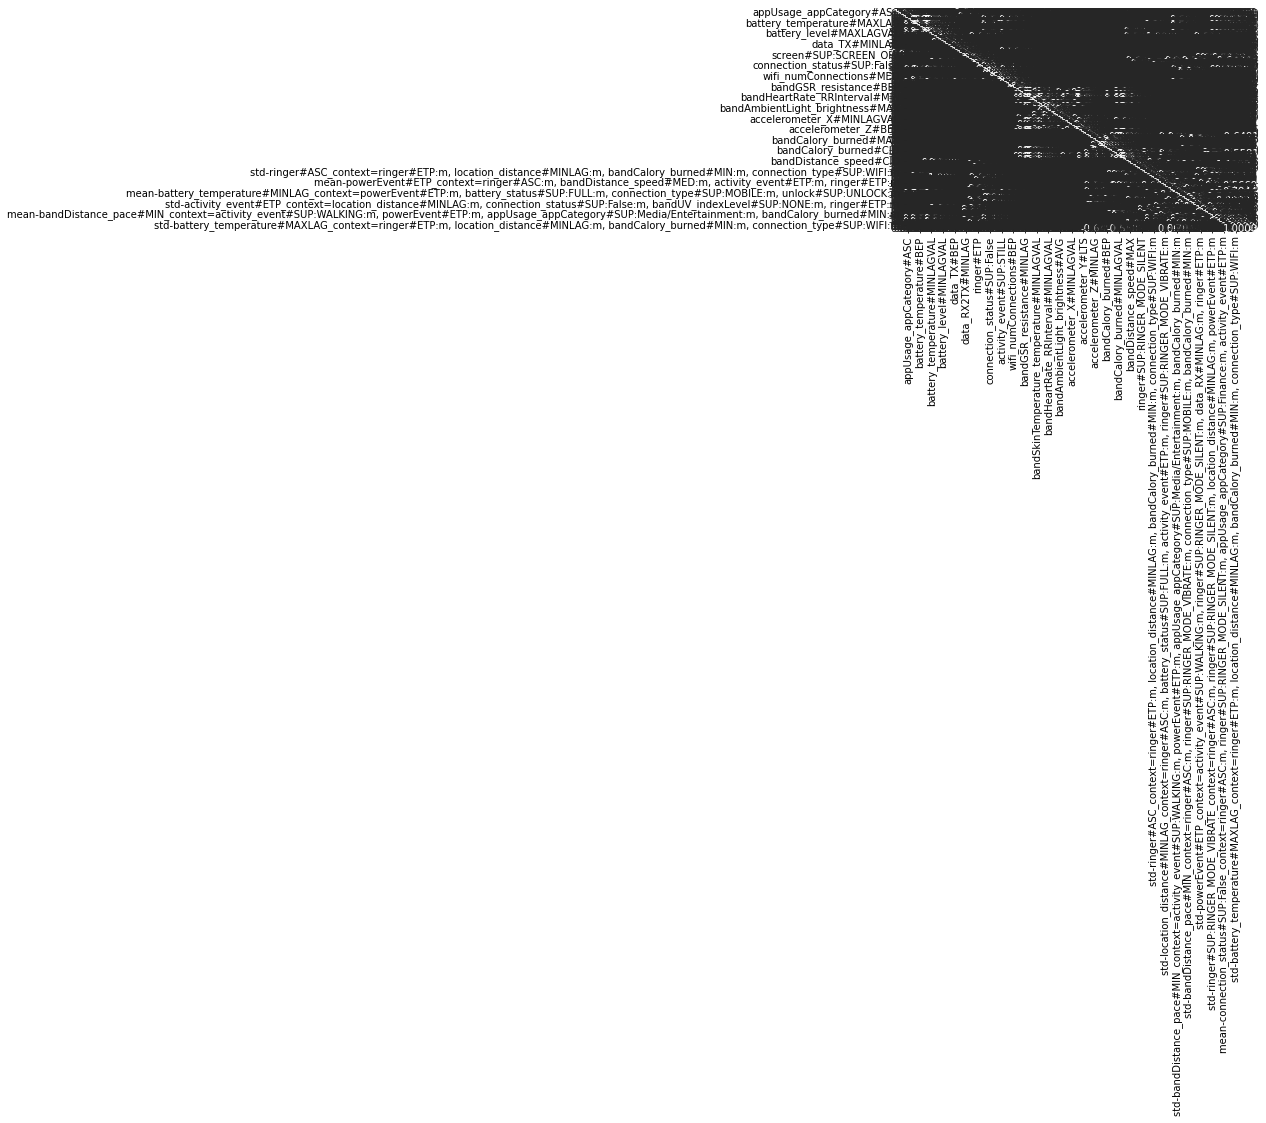

In [146]:
import seaborn as sns
fig, ax = plt.subplots()

sns.heatmap(data.corr(), annot=True, fmt='.4f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
plt.savefig('result.png', bbox_inches='tight', pad_inches=0.0)

# Effect of non time series features

In [112]:
extended_features = recept_dataset.extract_extended_parallel(
        labels=labels_ml
    )


Processing 3041
Processing 702
Processing 1505
Processing 1502
Processing 3009
Processing 1503
Processing 3010
Processing 714
Processing 719
Processing 708
Processing 721
Processing 712
Processing 1541
Processing 713
Processing 3022
Processing 706
Processing 710
Processing 3023
Processing 3030
Processing 1518
Processing 3025
Processing 1519
Processing 724
Processing 1522
Processing 1507
Processing 1509
Processing 1527
Processing 707
Processing 709
Processing 1517
Processing 1506


  0%|          | 0/37 [00:00<?, ?it/s]

Processing 3018
Processing 1514
Processing 1504
Processing 726
Processing 3029
Processing 1511


100%|██████████| 37/37 [13:42<00:00, 22.22s/it]  


FileNotFoundError: [Errno 2] No such file or directory: 'features/ml/extended.csv'

In [113]:
extended_features.to_csv(f'feature/ml/extended.csv')

In [115]:
extended_features = pd.read_csv(
        f'feature/ml/extended.csv',
        dtype={'pid':str},
        parse_dates=['timestamp']
    ).set_index(['pid','timestamp'])
    
# cast ESM features as numeric
M = extended_features.columns.str.startswith('ESM')
extended_features.iloc[
    :,M
] = extended_features.iloc[
    :,M
].astype(float)

extended_features

appUsage_appCategory#CUR#VAL  \
pid  timestamp                                          
3041 2019-05-01 10:30:08                        Tools   
     2019-05-01 11:26:31                        Tools   
     2019-05-01 13:00:57                        Tools   
     2019-05-01 14:31:22                        Tools   
     2019-05-01 15:11:33                        Tools   
...                                               ...   
1511 2019-05-22 16:40:14                    UNDEFINED   
     2019-05-22 18:09:50                        Tools   
     2019-05-22 18:56:25                        Tools   
     2019-05-22 19:47:55                        Tools   
     2019-05-22 21:08:00                        Tools   

                          battery_temperature#CUR#VAL  battery_level#CUR#VAL  \
pid  timestamp                                                                 
3041 2019-05-01 10:30:08                       28.423                 81.558   
     2019-05-01 11:26:31                       31.482                 67.591   
     2019-05-01 13:00:57                       34.645                 49.550   
     2019-05-01 14:31:22                       33.557                 34.000   
     2019-05-01 15:11:33                       33.700                 25.000   
...                                               ...                    ...   
1511 2019-05-22 16:40:14                       33.711                 85.301   
     2019-05-22 18:09:50                       30.907                 73.732   
     2019-05-22 18:56:25                       30.254                 68.000   
     2019-05-22 19:47:55                       29.657                 61.000   
     2019-05-22 21:08:00                       29.273                 56.000   

                         battery_plugState#CUR#VAL battery_status#CUR#VAL  \
pid  timestamp                                                              
3041 2019-05-01 10:30:08                 UNDEFINED            DISCHARGING   
     2019-05-01 11:26:31                 UNDEFINED            DISCHARGING   
     2019-05-01 13:00:57                 UNDEFINED            DISCHARGING   
     2019-05-01 14:31:22                 UNDEFINED            DISCHARGING   
     2019-05-01 15:11:33                 UNDEFINED            DISCHARGING   
...                                            ...                    ...   
1511 2019-05-22 16:40:14                 UNDEFINED            DISCHARGING   
     2019-05-22 18:09:50                 UNDEFINED            DISCHARGING   
     2019-05-22 18:56:25                 UNDEFINED            DISCHARGING   
     2019-05-22 19:47:55                 UNDEFINED            DISCHARGING   
     2019-05-22 21:08:00                 UNDEFINED            DISCHARGING   

                          data_RX#CUR#VAL  data_TX#CUR#VAL  \
pid  timestamp                                               
3041 2019-05-01 10:30:08            7.000            4.375   
     2019-05-01 11:26:31           35.250           21.537   
     2019-05-01 13:00:57           62.417           12.833   
     2019-05-01 14:31:22            1.000            0.000   
     2019-05-01 15:11:33           19.533            9.600   
...                                   ...              ...   
1511 2019-05-22 16:40:14          357.917           39.017   
     2019-05-22 18:09:50           10.000           11.000   
     2019-05-22 18:56:25         3403.400          115.000   
     2019-05-22 19:47:55            6.305            1.904   
     2019-05-22 21:08:00         3730.200          100.200   

                          data_RX2TX#CUR#VAL screen#CUR#VAL unlock#CUR#VAL  \
pid  timestamp                                                               
3041 2019-05-01 10:30:08              39.424      SCREEN_ON         UNLOCK   
     2019-05-01 11:26:31               1.644      SCREEN_ON         UNLOCK   
     2019-05-01 13:00:57              13.015      SCREEN_ON         UNLOCK   
     2019-05-01 14:31:22             102.75

In [116]:
extended_features['activity_event#CUR#VAL'] = extended_features[
    'activity_event#CUR#VAL'
].map({
    'missing':0,
    'STILL':0
    , 'IN_VEHICLE':1
    , 'on_BICYCLE':2
    , 'WALKING':3
})


extended_features['activity_event#CUR#VAL'] = extended_features[
    'activity_event#CUR#VAL'
].astype(float)


extended_features['TIM#CUR#DOW'] = extended_features[
    'TIM#CUR#DOW'
].map({ 
    'MON':0
    , 'TUE':1
    , 'WED':2
    , 'THU':3
    , 'FRI':4
    , 'SAT':5
    ,'SUN':6
}).astype(float)


extended_features['TIM#CUR#HRN'] = extended_features[
    'TIM#CUR#HRN'
].map({
    'LATE_AFTERNOON':0
    , 'EVENING':1
    , 'AFTERNOON':2
    , 'NIGHT':3
    , 'MORNING':4    
}).astype(float)

extended_features['TIM#CUR#WKD'] = extended_features['TIM#CUR#WKD'].astype(float)

In [117]:

M_cat = extended_features.dtypes!=float
cat_features = extended_features.columns[M_cat].to_list()
num_features = extended_features.columns[~M_cat].to_list()

extended_features[cat_features] = extended_features[cat_features].fillna('missing').astype('str')
len(cat_features),len(num_features)

(11, 34)

In [131]:
len(cat_features)

11

In [140]:
# import preprocessing from sklearn
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
extended_features_enc =  pd.merge(
    impute(normalize(extended_features[num_features]))
    ,extended_features[cat_features].apply(le.fit_transform)
    , left_index=True
    , right_index= True 
).astype(float)

/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [141]:
extended_features_enc.isnull().sum(axis=0)


battery_temperature#CUR#VAL                0
battery_level#CUR#VAL                      0
data_RX#CUR#VAL                            0
data_TX#CUR#VAL                            0
data_RX2TX#CUR#VAL                         0
location_distance#CUR#VAL                  0
activity_event#CUR#VAL                     0
wifi_numConnections#CUR#VAL                0
bandGSR_resistance#CUR#VAL                 0
bandHeartRate_BPM#CUR#VAL                  0
bandSkinTemperature_temperature#CUR#VAL    0
bandHeartRate_RRInterval#CUR#VAL           0
bandAmbientLight_brightness#CUR#VAL        0
accelerometer_X#CUR#VAL                    0
accelerometer_Y#CUR#VAL                    0
accelerometer_Z#CUR#VAL                    0
bandUV_exposureToday#CUR#VAL               0
bandUV_exposure#CUR#VAL                    0
bandPedometer_step#CUR#VAL                 0
bandPedometer_stepsToday#CUR#VAL           0
bandCalory_burned#CUR#VAL                  0
bandCalory_burnedToday#CUR#VAL             0
bandDistan

In [143]:
data = pd.merge(
    labels_ml[['receptivity']]
    ,extended_features_enc.drop('RCT#AVG#disturbance',axis=1),
    left_index=True, right_index=True
)

measure_extended = run_classification(
    data, 
    use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='catbost-with-categoricals'
    , classifier_name='lr'
)
measure_extended.groupby(['CV_TYPE','experiment']).mean()

5it [00:00, 15.96it/s]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,catbost-with-categoricals,58.606,56.388,0.545,0.560,68.123,64.866,0.649,0.706


## only numeric features

In [144]:
data = pd.merge(
    labels_ml[['receptivity']]
    , impute(
        normalize(
            extended_features[num_features].drop('RCT#AVG#disturbance',axis=1)
        )
    ),
    left_index=True, right_index=True
)

measure_extended = run_classification(
    data, 
    use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='catbost-with-categoricals'
    , classifier_name='lr'
)
measure_extended.groupby(['CV_TYPE','experiment']).mean()

/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
5it [00:00, 48.75it/s]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,catbost-with-categoricals,57.887,56.124,0.534,0.583,66.798,63.006,0.627,0.689


## user hist only

In [130]:
data = pd.merge(
    labels_ml[['receptivity']]
    , impute(
        normalize(
            extended_features[['RCT#AVG#disturbance']]
        )
    ),
    left_index=True, right_index=True
)

measure_extended_hist = run_classification(
    data, 
    use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='catbost-with-categoricals'
    , classifier_name='lr'
)
measure_extended_hist.groupby(['CV_TYPE','experiment']).mean()

5it [00:00, 77.48it/s]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,catbost-with-categoricals,70.601,65.362,0.652,0.728,71.148,67.444,0.675,0.744


## combined 

In [133]:
measure_combined_w_fs

,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC,CV_TYPE,experiment
0,56.438,54.878,0.549,0.571,78.546,77.207,0.776,0.866,LOGO_5fold,Combined: Full+Agg+CFF
1,69.774,69.214,0.693,0.749,76.786,74.530,0.751,0.829,LOGO_5fold,Combined: Full+Agg+CFF
2,52.907,52.933,0.529,0.541,79.149,77.253,0.777,0.866,LOGO_5fold,Combined: Full+Agg+CFF
3,58.621,59.494,0.586,0.613,79.161,77.361,0.779,0.858,LOGO_5fold,Combined: Full+Agg+CFF
4,73.469,59.824,0.606,0.641,78.951,78.540,0.787,0.854,LOGO_5fold,Combined: Full+Agg+CFF


In [145]:
data = pd.merge(
    labels_ml[['receptivity']]
    , impute(
        normalize(
            extended_features_enc.drop('RCT#AVG#disturbance',axis=1)
        )
    ),
    left_index=True, right_index=True
)

data = pd.merge(
    data
    ,data_combined_full_agg_cff
    ,left_index=True, right_index=True
)


measure_extended_hist = run_classification(
    data, 
    use_ray=use_ray, feature_selection=feature_selection,
    experiment_name='catbost-with-categoricals'
    , classifier_name='lr'
)
measure_extended_hist.groupby(['CV_TYPE','experiment']).mean()

/home/juma/miniconda3/envs/recept/lib/python3.7/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
5it [00:00,  7.92it/s]


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,catbost-with-categoricals,61.313,58.737,0.587,0.627,80.403,78.954,0.794,0.877


# Reporting results

### Effect of feature engineering

In [74]:
cff_measure_w_fs.groupby(['CV_TYPE','experiment']).mean()


,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,,,,,,,,
LOGO_5fold,lr-CFF,58.843,56.096,55.805,0.611,67.814,65.641,65.535,0.720


In [78]:
ML_AGG_RESULT.groupby([
    'CV_TYPE','experiment', 'feature_type','feature_dim'
]).mean()

,,,,TEST_ACC,TEST_ACC_BAL,TEST_F1_score,TEST_AUC,TRAIN_ACC,TRAIN_ACC_BAL,TRAIN_F1_score,TRAIN_AUC
CV_TYPE,experiment,feature_type,feature_dim,,,,,,,,
LOGO_5fold,Logistic Regression,aggregated features,191,59.415,56.333,55.640,0.591,74.416,72.213,72.671,0.807


In [ ]:
full_measure_w_fs.groupby(['CV_TYPE','experiment']).mean()

In [98]:
effect_of_FE = pd.concat([
    full_measure_w_fs
    , ML_AGG_RESULT_W_FS
    , cff_measure_w_fs
])[['feature_type','feature_dim', 'TEST_AUC', 'TEST_F1_score']]

effect_of_FE.groupby([
     'feature_type','feature_dim'
]).mean().to_csv('effect_of_FE.csv')

In [150]:
effect_of_FE.groupby([
     'feature_type','feature_dim'
]).mean()

,,TEST_AUC,TEST_F1_score
feature_type,feature_dim,,
Contextually Filtered Features,32,0.611,55.805
aggregated features,191,0.591,55.640
temporal/full,102,0.569,55.770
